In [1]:
from load import *
import torchmetrics
from tqdm import tqdm

import os
import openai
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
import logging
import sys
import re
from IPython.display import HTML
openai.api_key  = os.getenv('OPENAI_API_KEY')

/home/kush/Desktop/classify_by_description_release
Creating descriptors...

Example description for class Black-footed Albatross: "Black-footed Albatross, which is a seabird"



/home/kush/anaconda3/envs/kush/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


# Load model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device, jit=False)
model = model.eval()
model = model.requires_grad_(False)

# Function for computing Label text emebddings

In [3]:
def compute_encodings(model, labels):
    with torch.no_grad():
        label_encodings = F.normalize(model.encode_text(clip.tokenize(labels, truncate=True).to(device)))
    return label_encodings

# Function for index to label

In [4]:
def idx_to_label(label_to_idx):
    dataset_items = list(label_to_idx.items())
    return dict(map(lambda x: x[::-1], dataset_items))

In [5]:
def initialize_counter_dict(labels):
    dict_ = dict()
    for label1 in labels:
        dict_[label1] = dict()
        for label2 in labels:
            dict_[label1][label2] = 0
    return dict_

In [6]:
def increase_count(counter_dict, actual_class, top_classes):
    for class_ in top_classes:
        counter_dict[actual_class][class_] += 1
    return counter_dict

In [7]:
def add_to_counter_dict(counter_dict, index_to_class_dict, actual_index_list, 
                        pred_index_list, topK_is_one = False):
    for idx, actual_class_index in enumerate(actual_index_list):
        actual_class = index_to_class_dict[int(actual_class_index)]
        if topK_is_one == True:
            top_classes = list(map(lambda x: index_to_class_dict[int(x)], 
                               list(pred_index_list[idx])))
        else:
            top_classes = list(map(lambda x: index_to_class_dict[int(x)], 
                               pred_index_list[idx].squeeze()))
        counter_dict = increase_count(counter_dict, actual_class, top_classes)
    return counter_dict

In [8]:
def calc_acc(model, dataset, descriptions, batch_size = 64*10, count_classes = False, 
             topK = 5):
    topK_is_one = False
    if topK == 1:
        topK = 5
        topK_is_one = True
    elif topK < 1:
        return "Please use k >= 1!"
    
    count_classes_dict = initialize_counter_dict(dataset.classes)
    index_to_class_dict = idx_to_label(dataset.class_to_idx)
    
    
    encodings = compute_label_encodings(model)
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_topk = torchmetrics.Accuracy(top_k=topK, task="multiclass", num_classes=len(dataset.classes)).to(device)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ encodings.T
        topk_values, topk_indices = image_labels_similarity.topk(topK, dim=1)
        clip_predictions = image_labels_similarity.argmax(dim=1)


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_acc_topk = clip_accuracy_metric_topk(image_labels_similarity, labels)
        
        
        if count_classes == True:
            count_classes_dict = add_to_counter_dict(count_classes_dict, index_to_class_dict,
                                                 labels, topk_indices, topK_is_one)

    # Make Top k 1 again
    
    if topK_is_one == True:
        topK = 1

    accuracy_logs = {}
    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    if topK > 1:
        accuracy_logs[f"Total CLIP-Standard Top-{topK} Accuracy: "] = 100*clip_accuracy_metric_topk.compute().item()
    
    if count_classes == True:
        for actual_key in count_classes_dict.keys():
            count_classes_dict[actual_key] = sorted(count_classes_dict[actual_key].items(),
                                                key=lambda x: x[1], reverse=True)

        json_string = json.dumps(count_classes_dict, indent=4)  # indent for pretty formatting

        if topK_is_one == True:
            topK = 1
        # Write JSON string to a text file
        with open(f'top{topK}.txt', 'w') as file:
            file.write(json_string)

    
    return accuracy_logs

In [9]:
calc_acc(model, dataset, dataset.classes,
         count_classes = True, topK=5)

100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


{'Total CLIP-Standard Top-1 Accuracy: ': 51.28461718559265,
 'Total CLIP-Standard Top-5 Accuracy: ': 81.96529746055603}

# Test Accuracy

# Graphs

In [10]:
def create_graph(actual_label, top5_pred):
    top5labels = list(map(lambda x: x[0], top5_pred))
    top5counts = list(map(lambda x: x[1], top5_pred))
    colors = ['royalblue' if label == actual_label else 'lightsteelblue' for label in top5labels]
    plt.barh(top5labels, top5counts, color=colors)

    num_ticks = 6  # Adjust the number of ticks as needed
    tick_positions = np.linspace(0, max(top5counts), num_ticks)
    plt.xticks(tick_positions, rotation=45, ha='right')  # Set the rotation and horizontal alignment

    plt.xlabel('Top-5 counts')
    plt.ylabel('Classes')
    plt.title('Score-wise Diagram')
    
    # Show the plot
    plt.show()


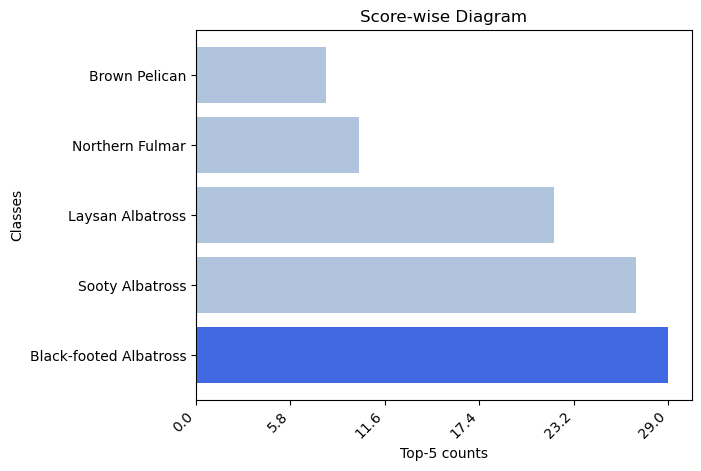

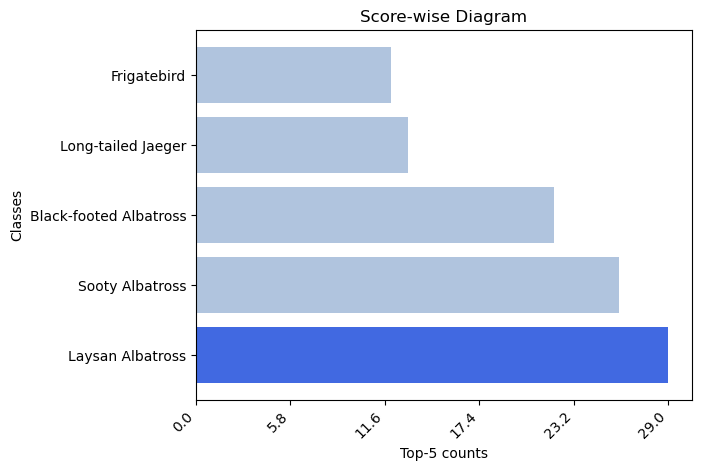

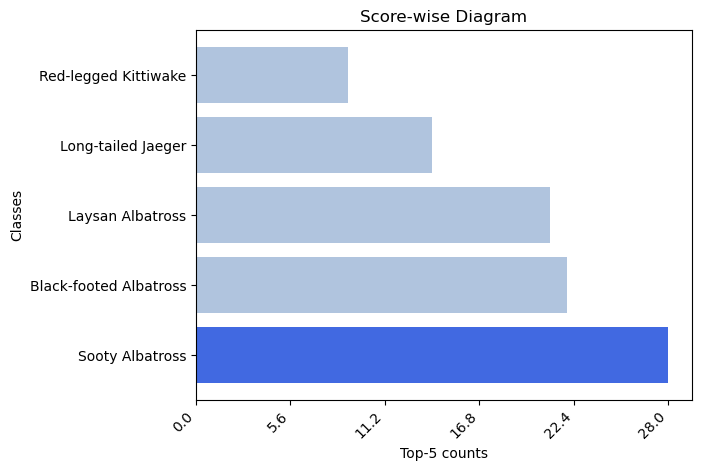

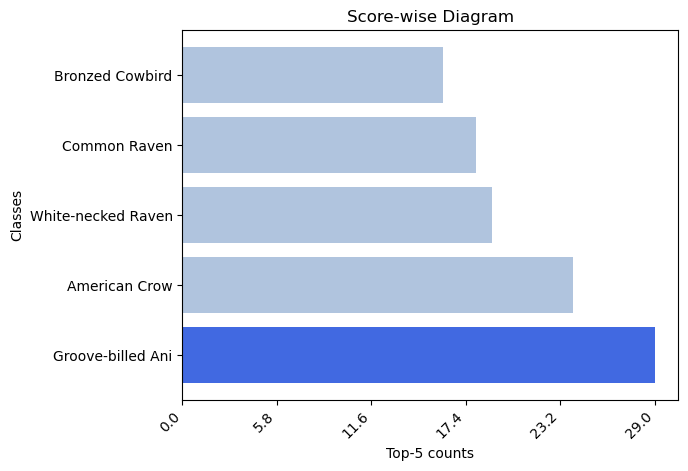

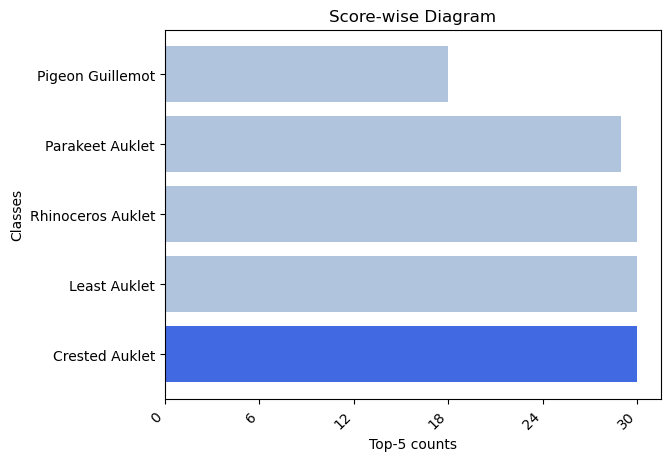

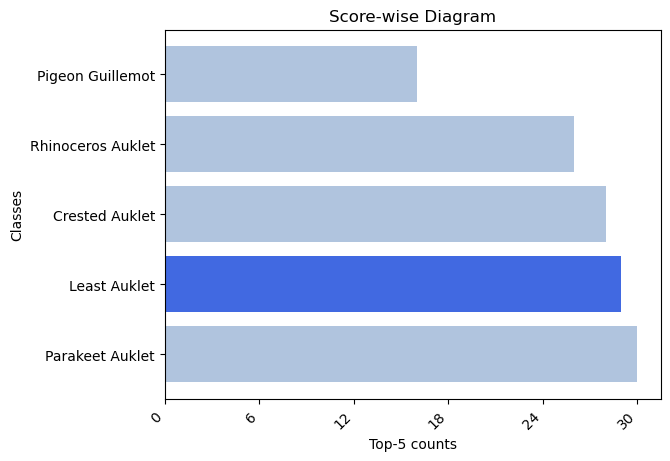

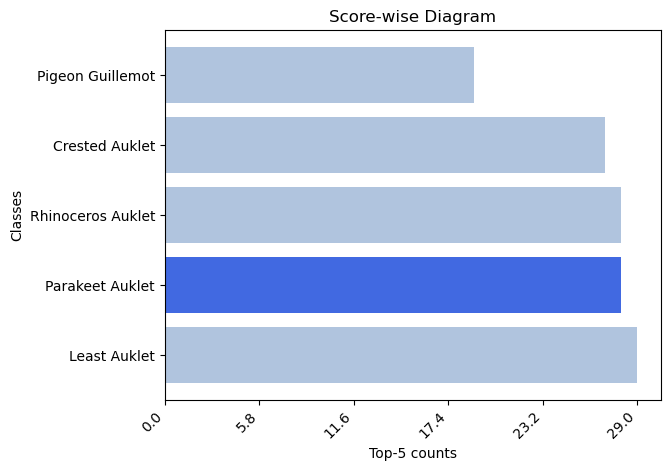

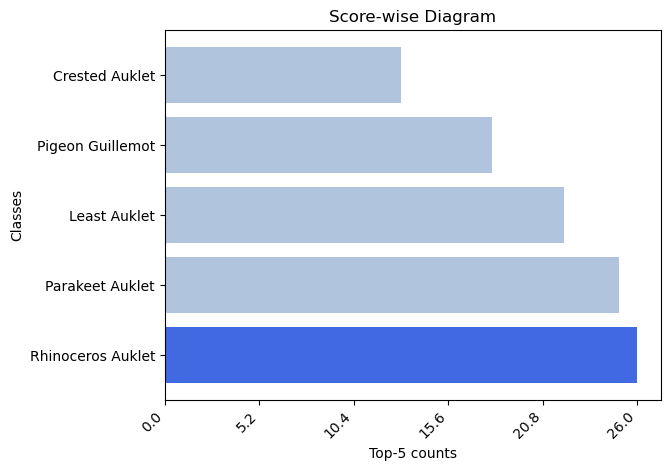

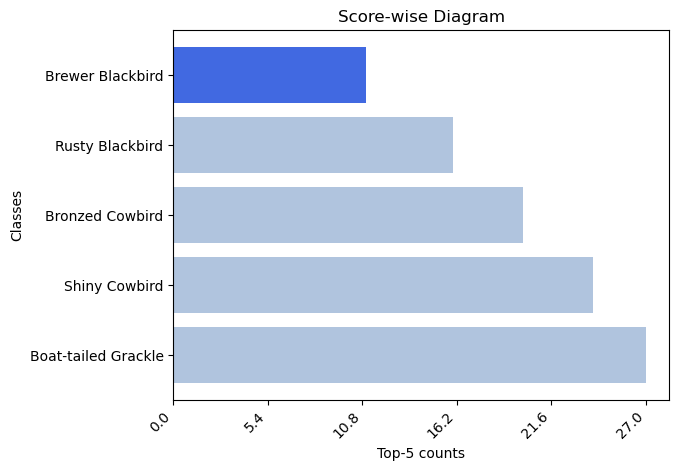

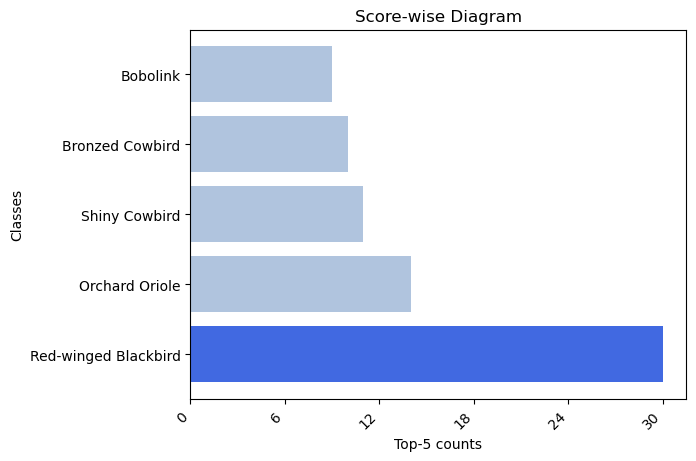

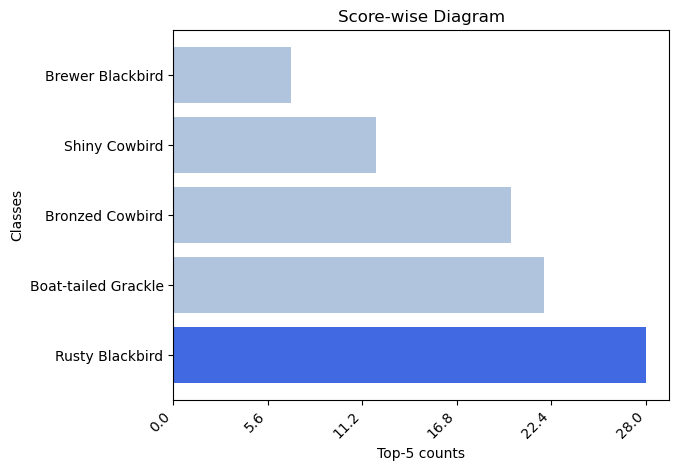

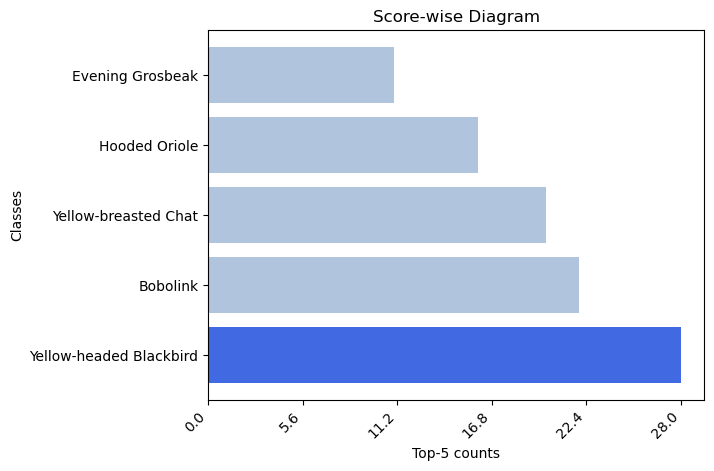

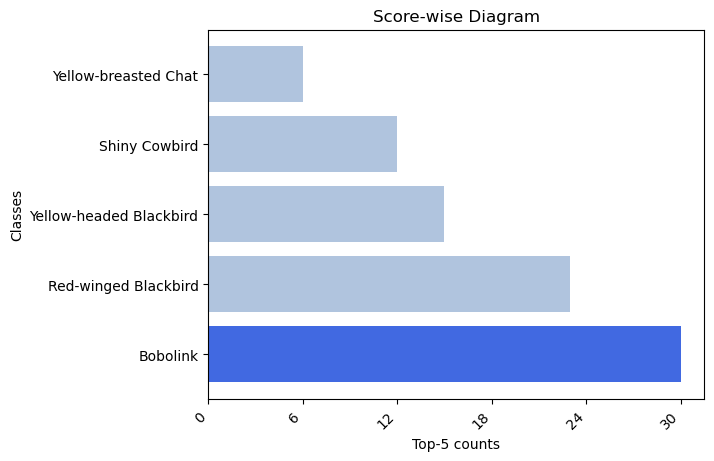

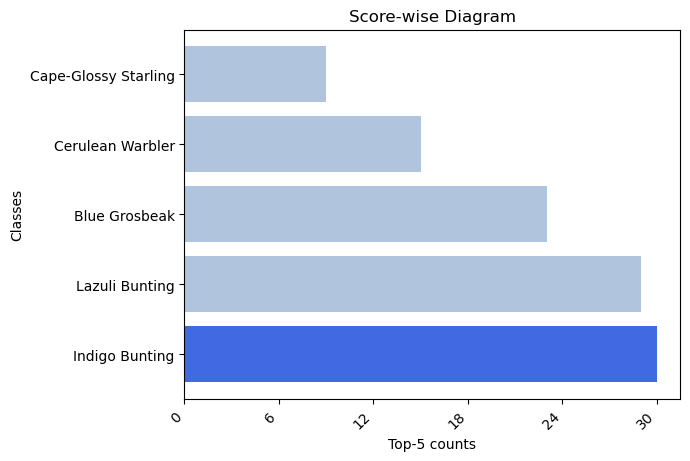

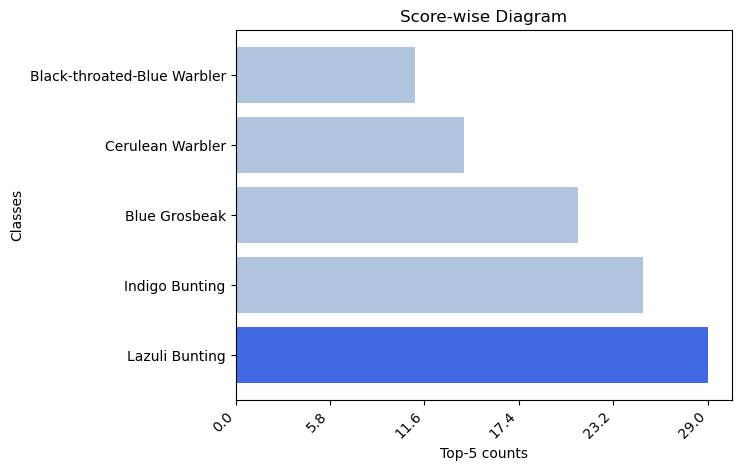

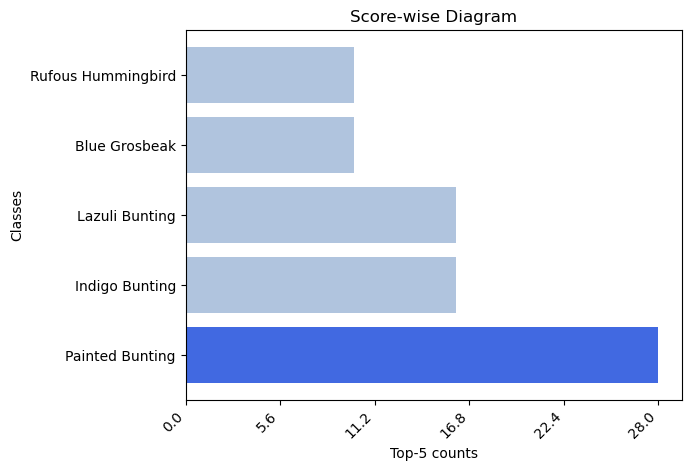

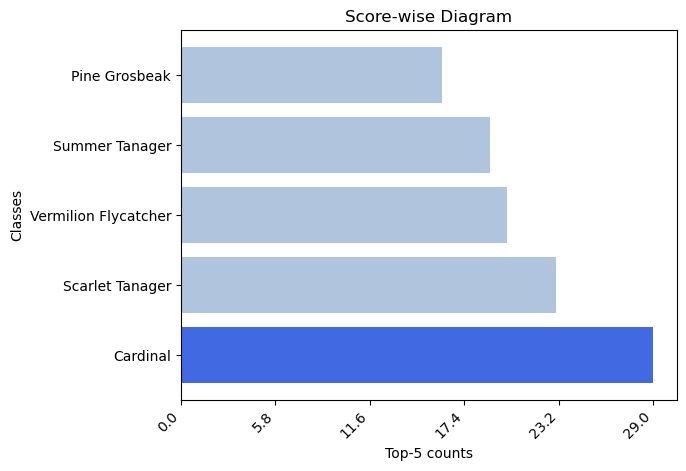

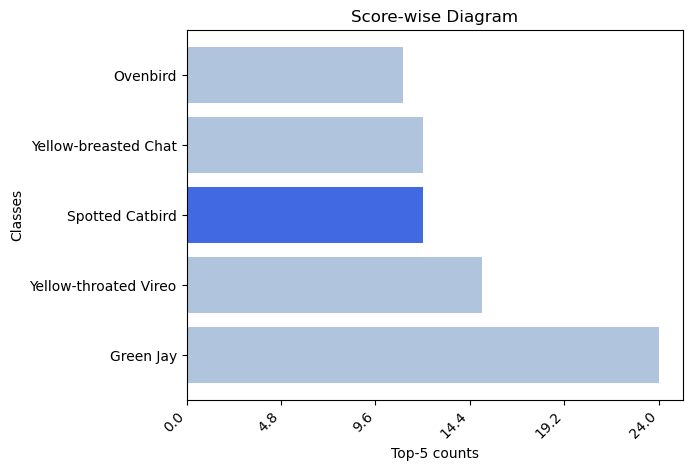

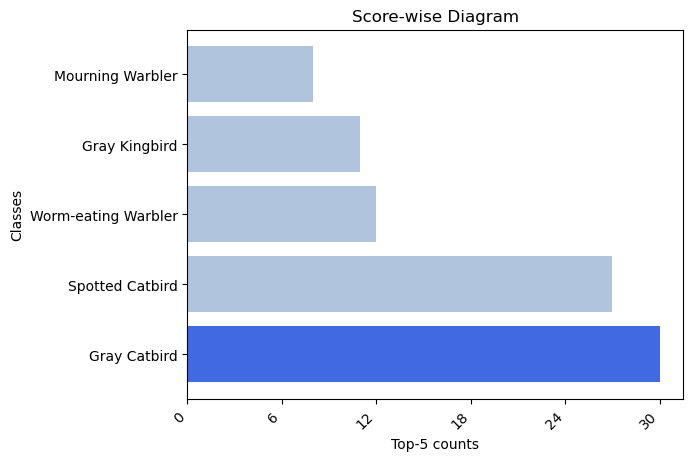

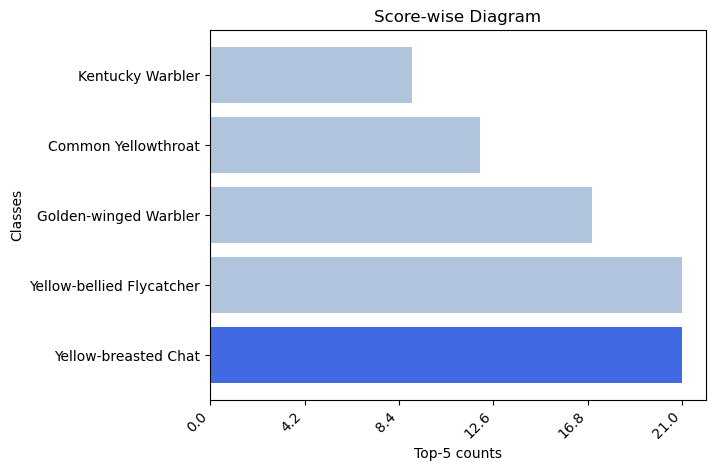

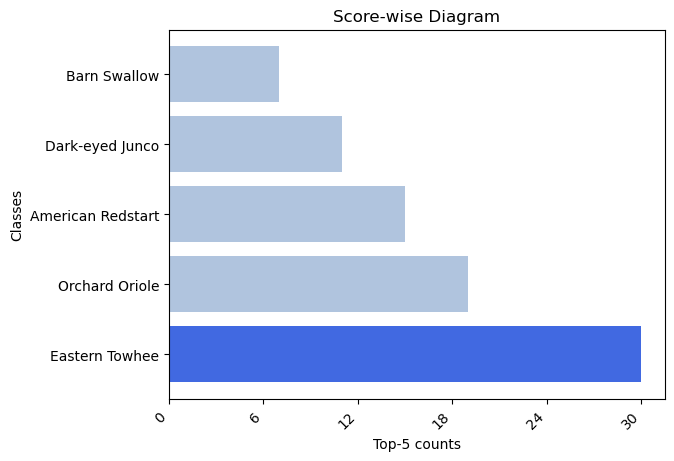

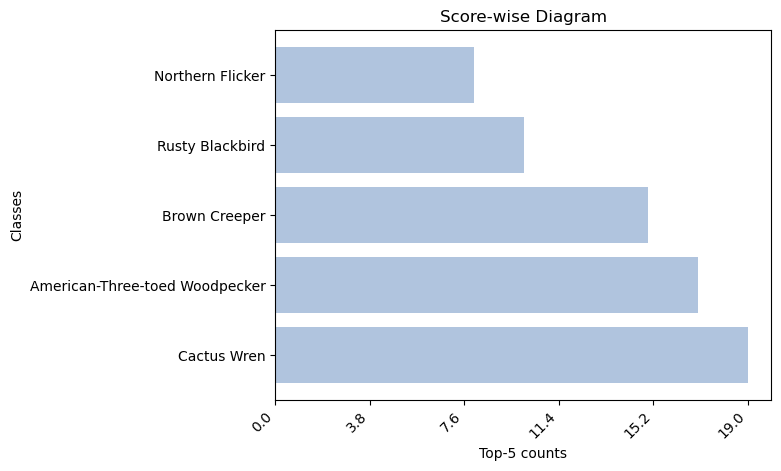

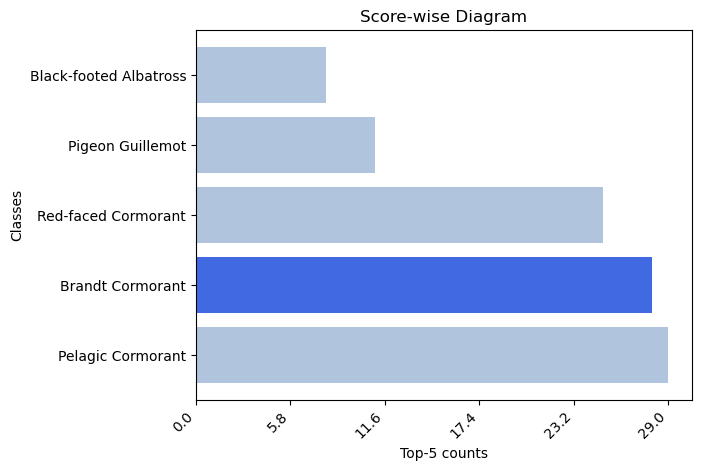

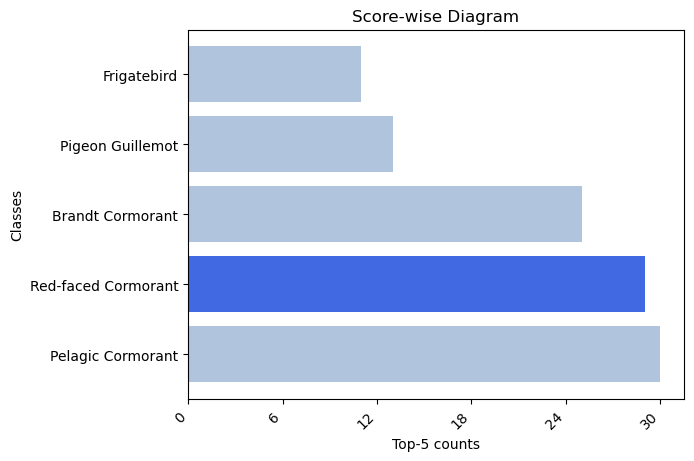

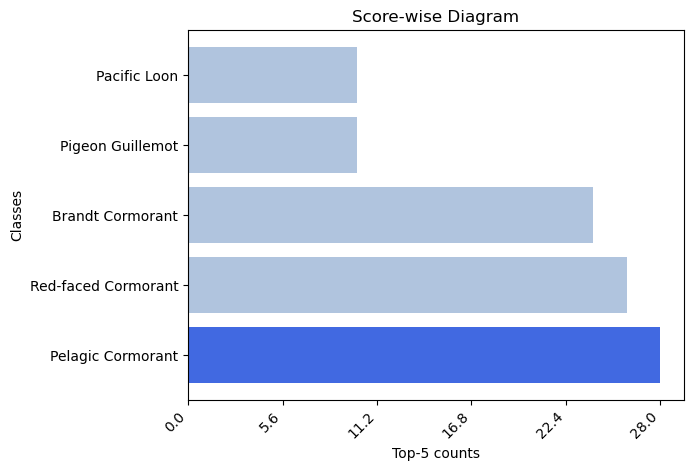

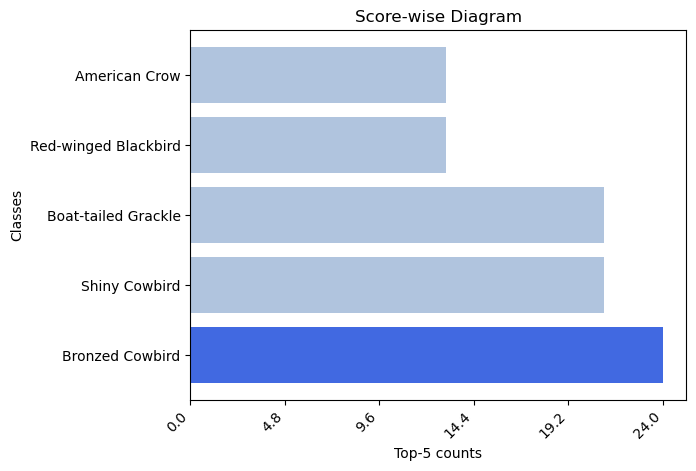

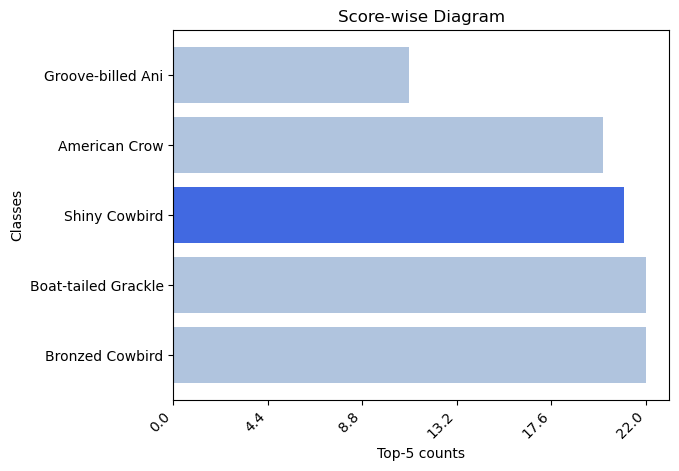

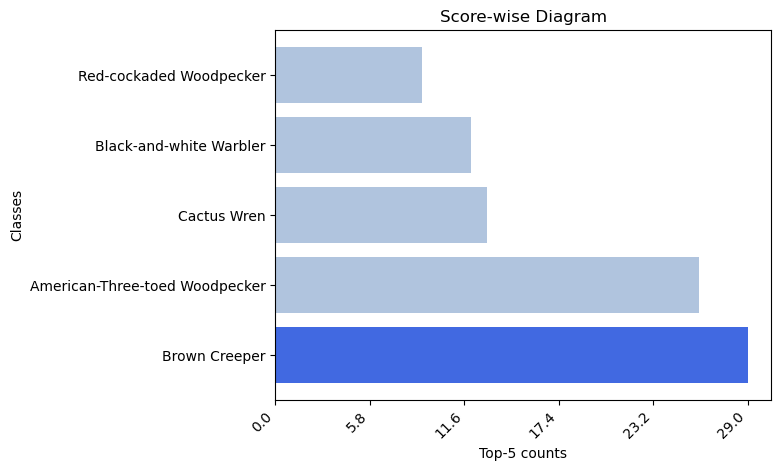

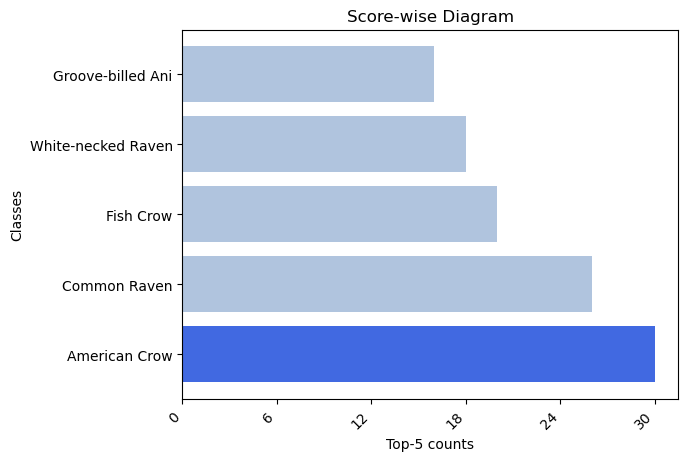

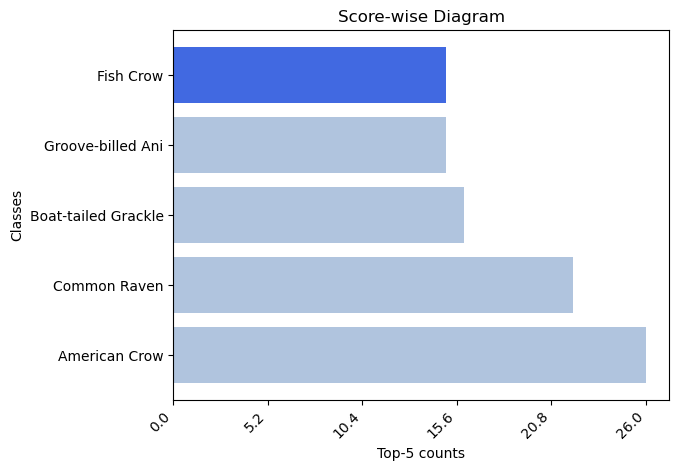

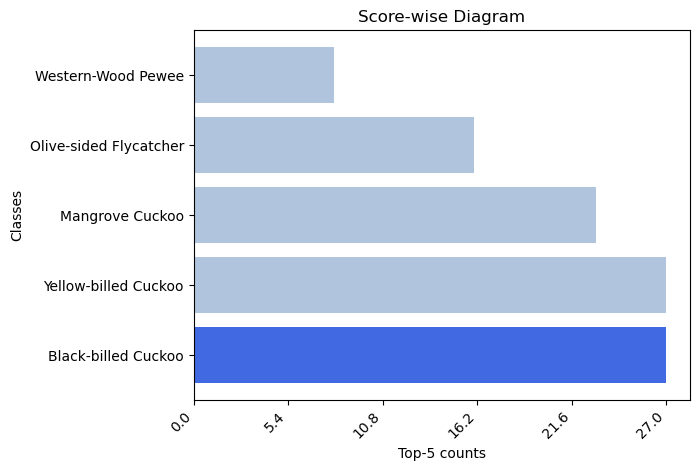

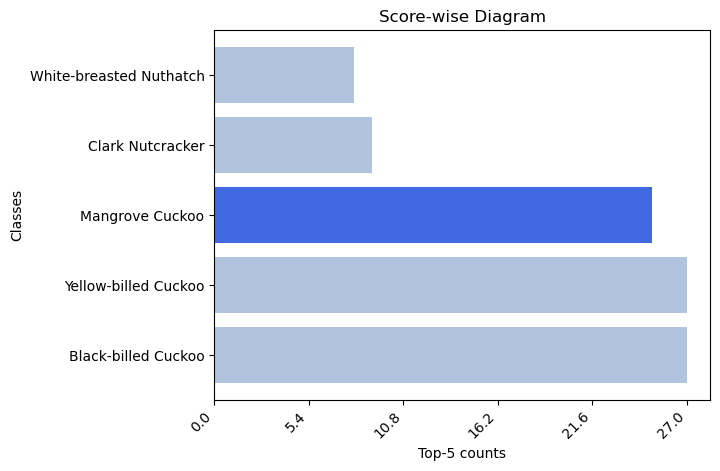

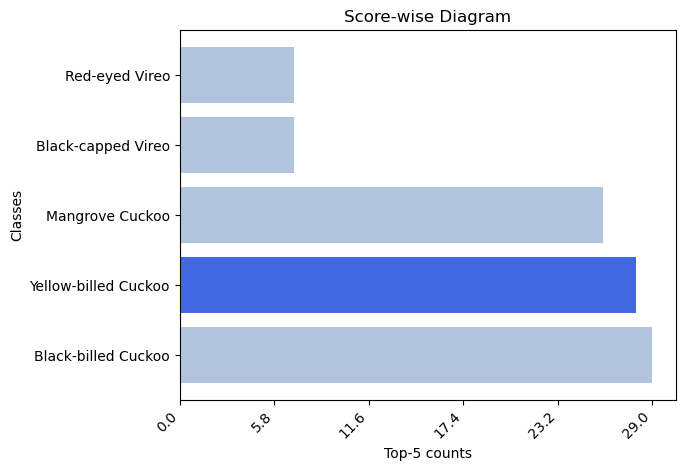

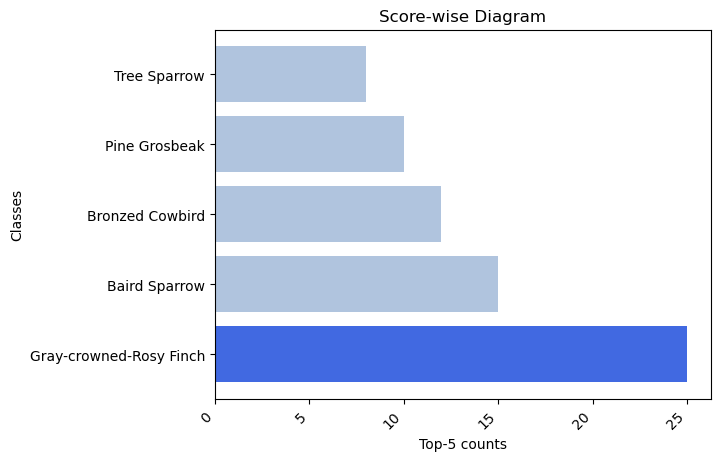

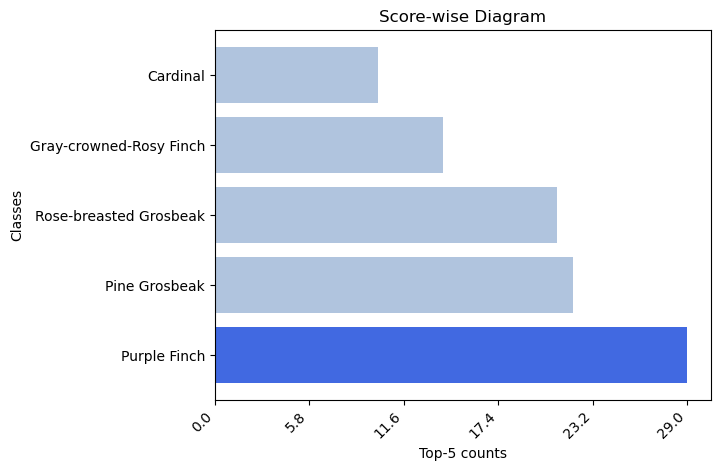

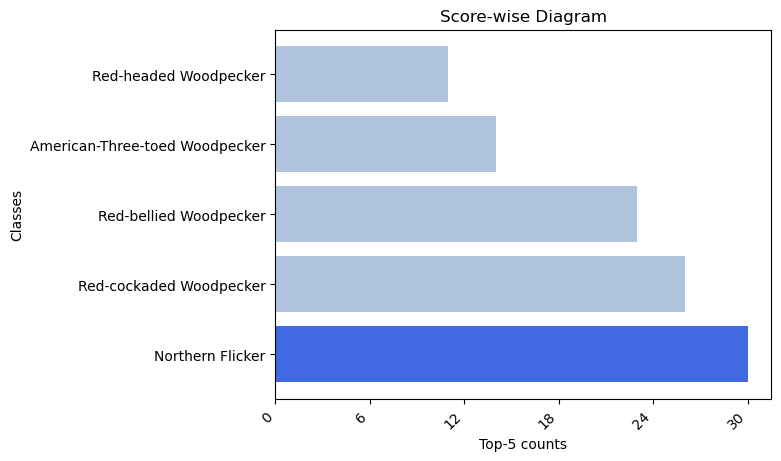

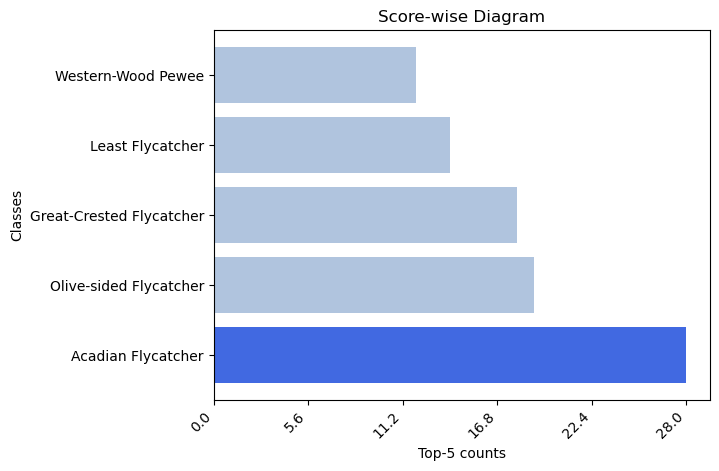

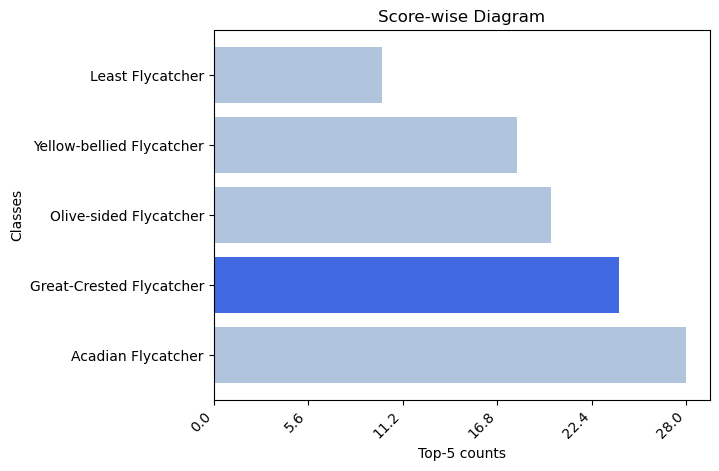

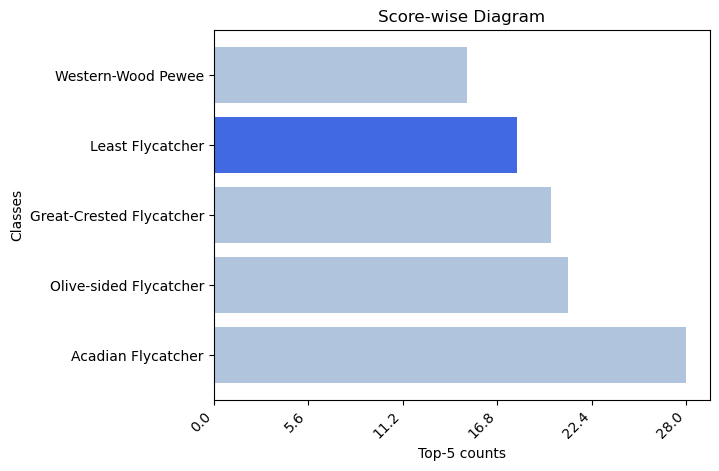

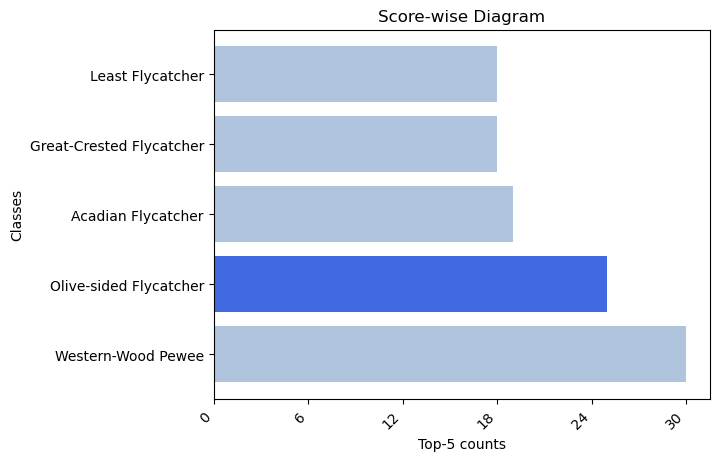

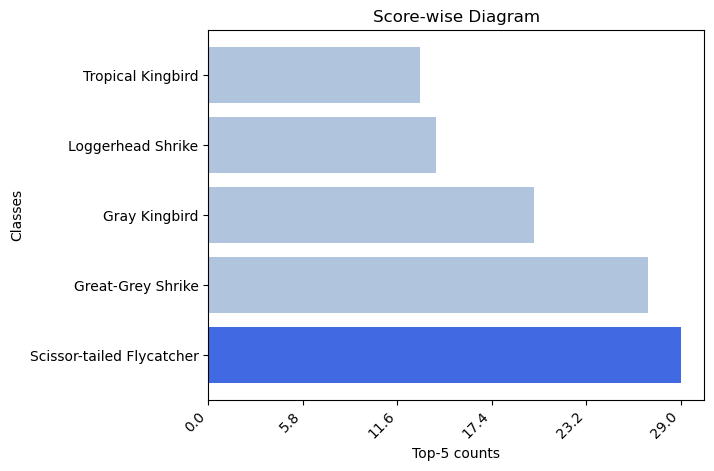

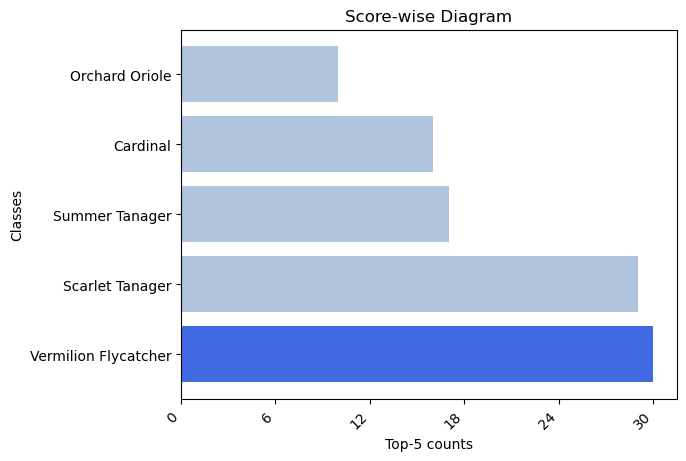

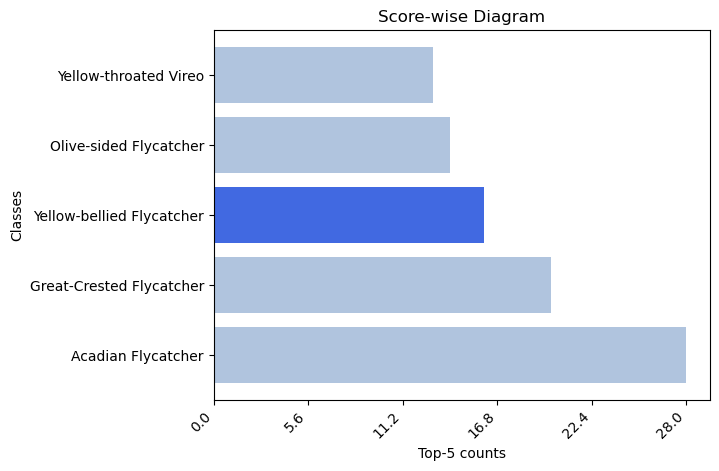

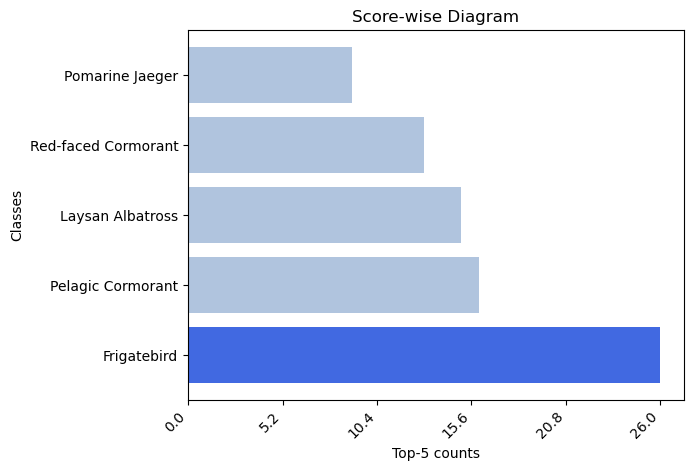

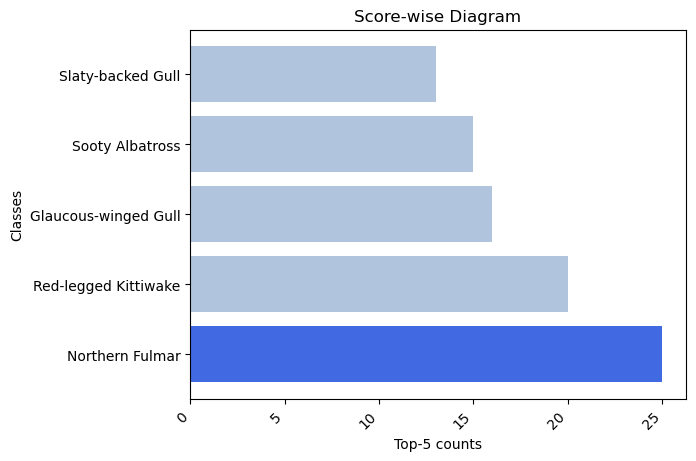

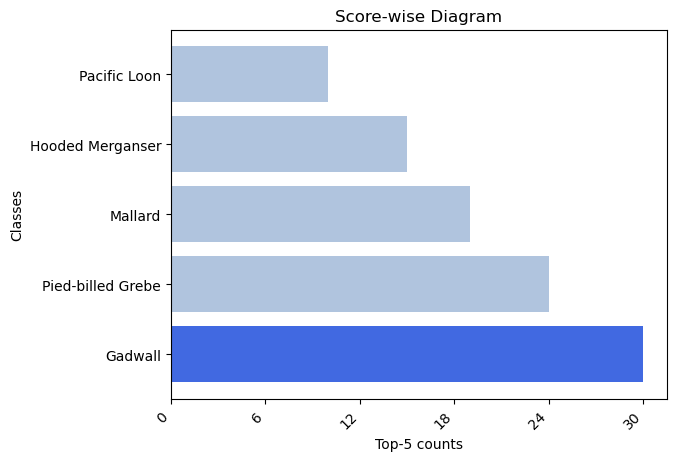

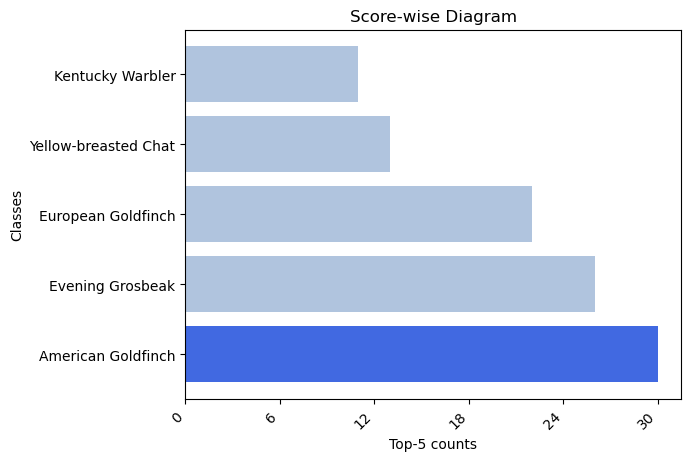

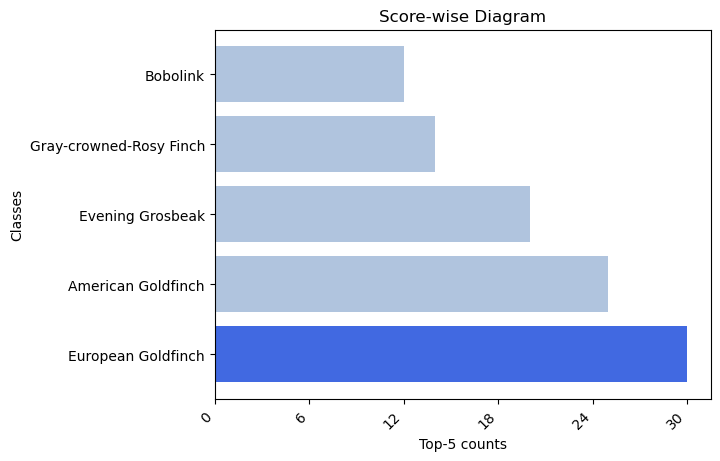

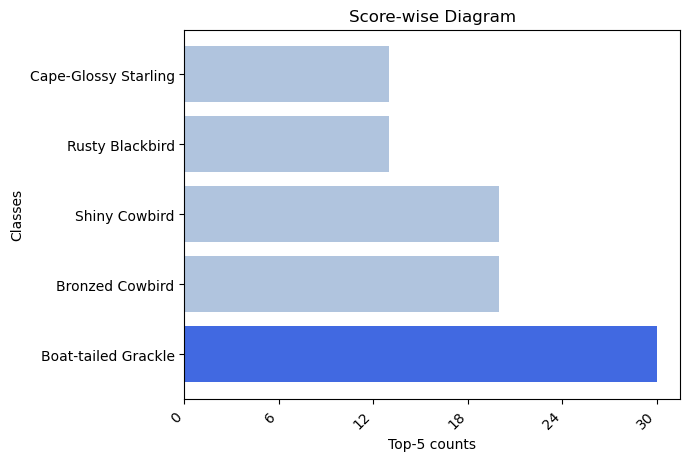

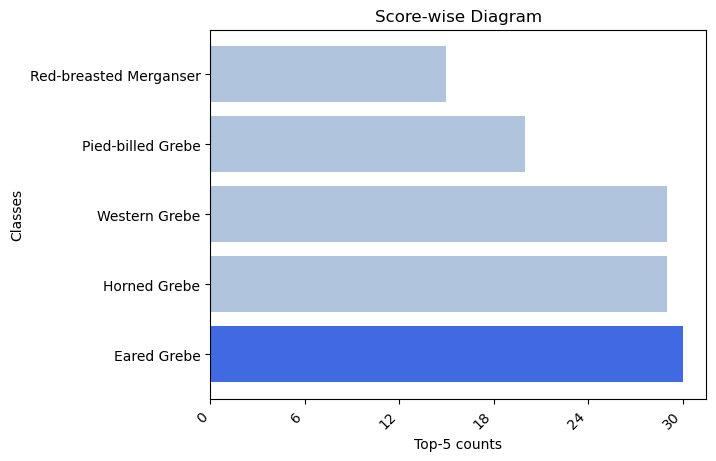

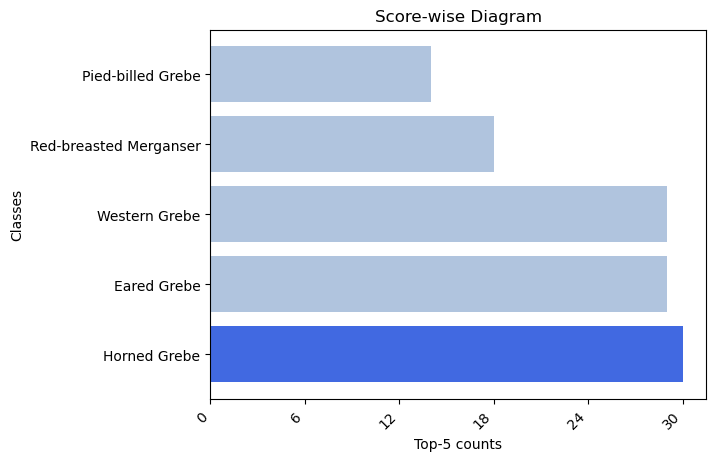

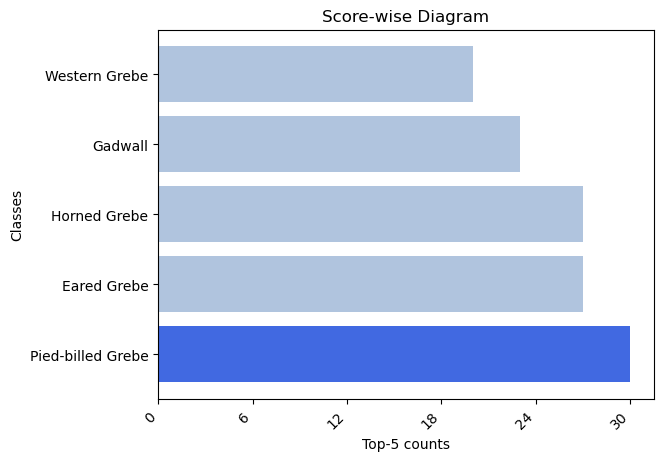

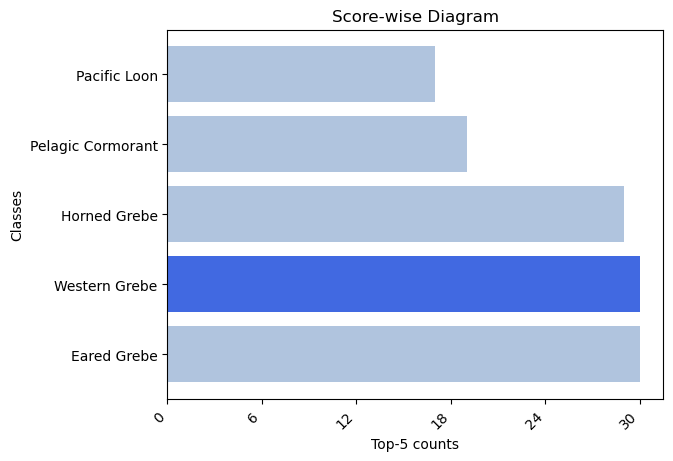

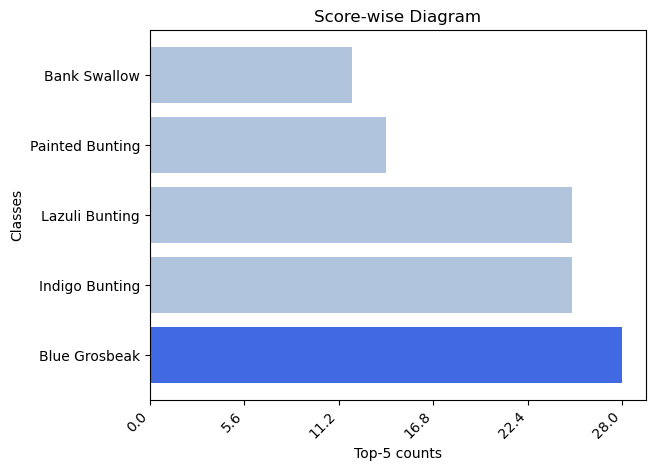

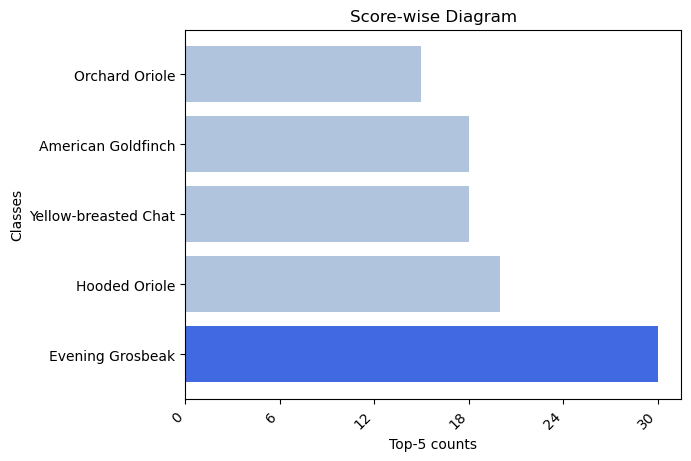

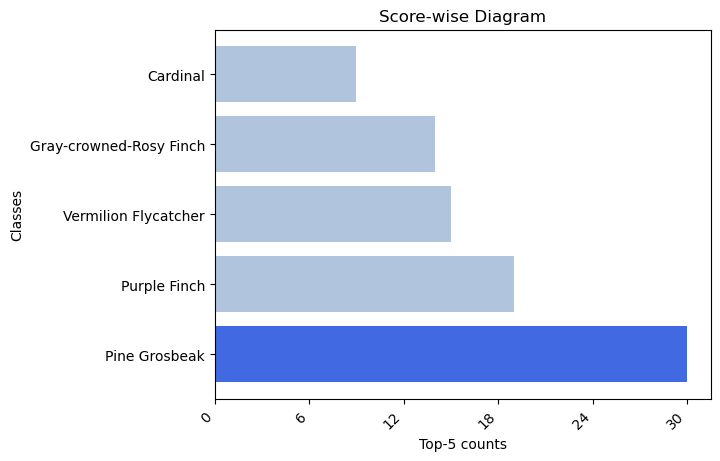

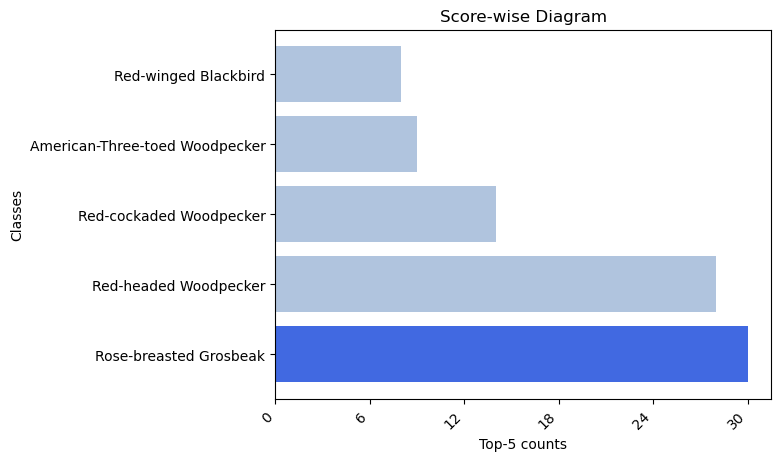

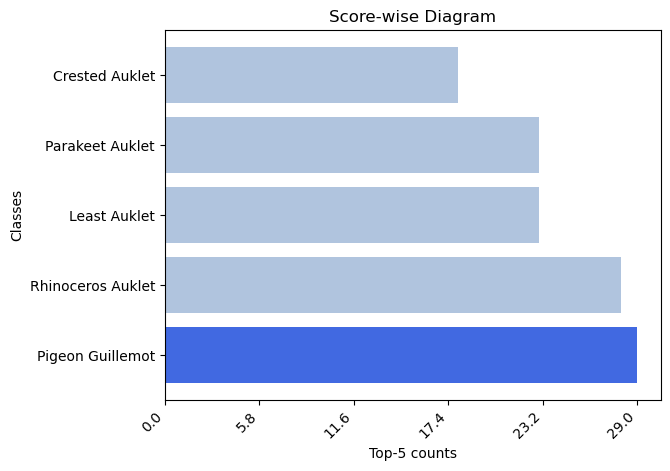

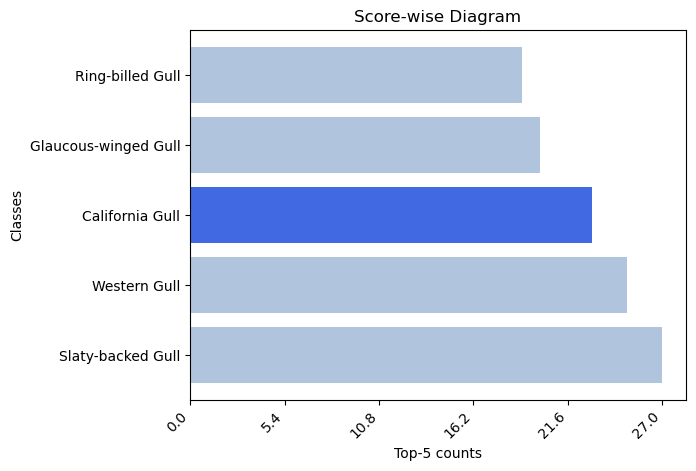

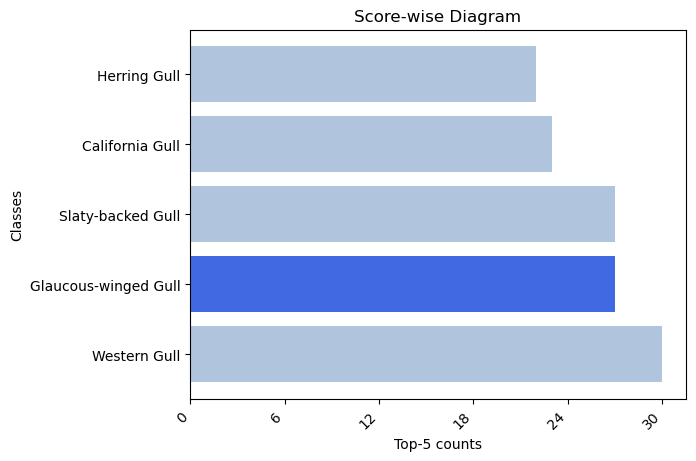

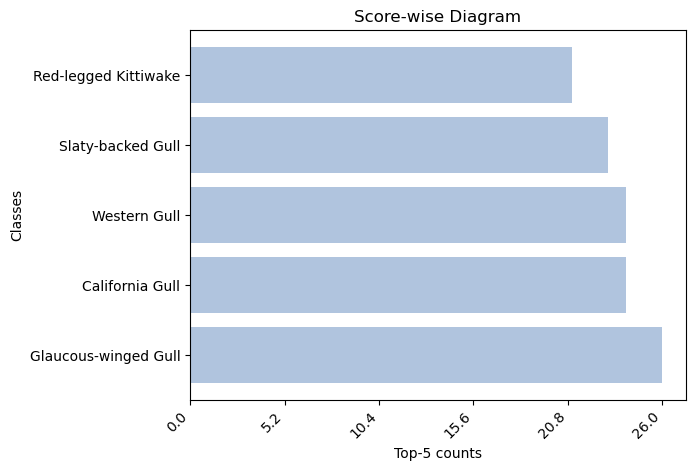

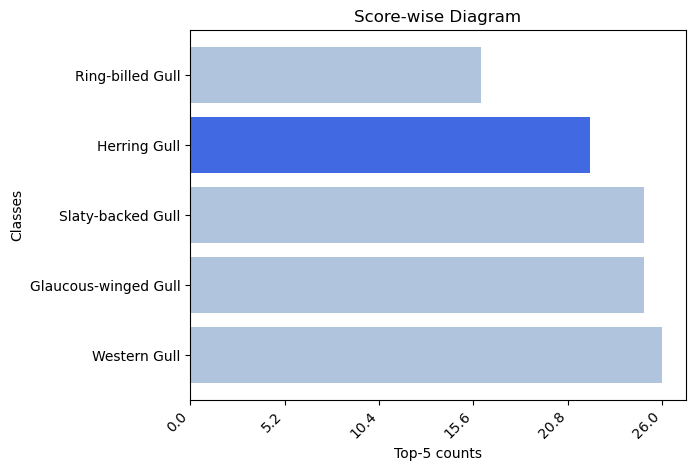

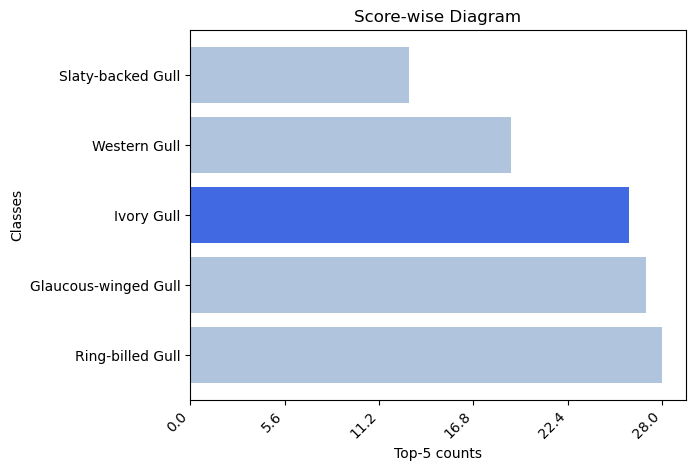

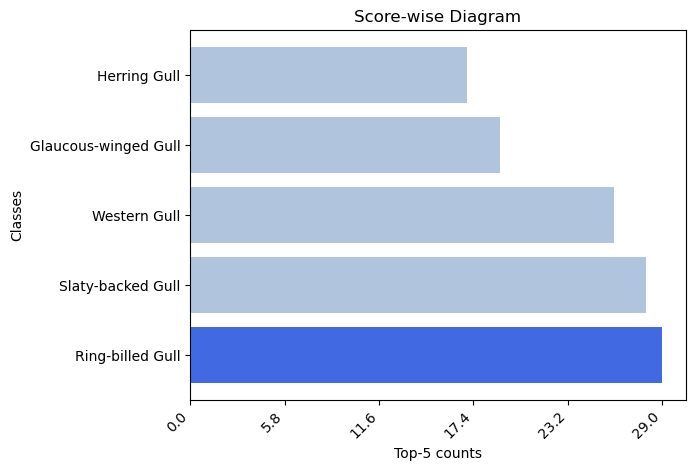

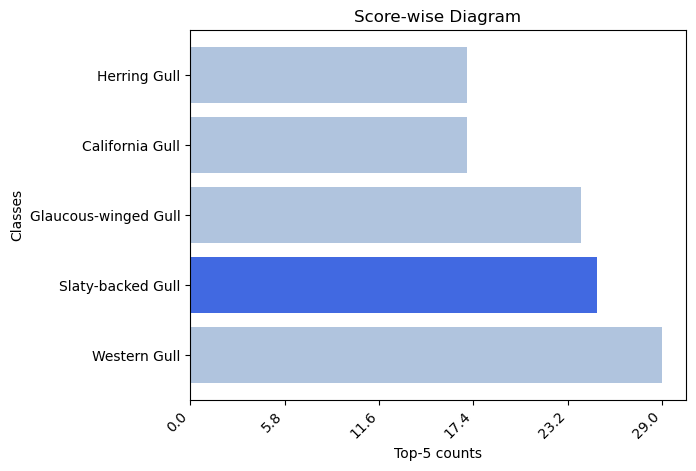

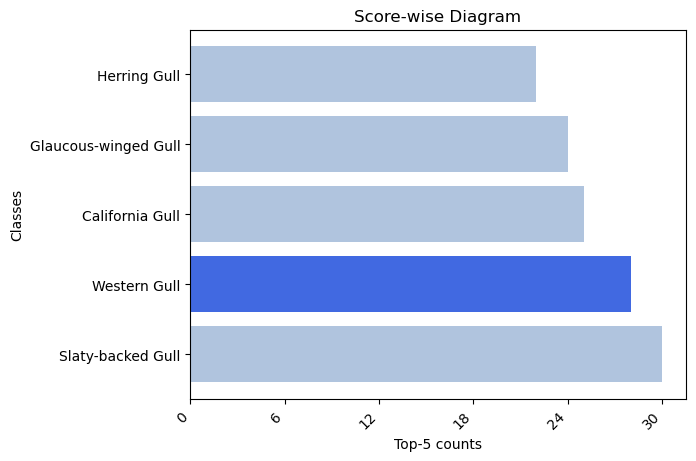

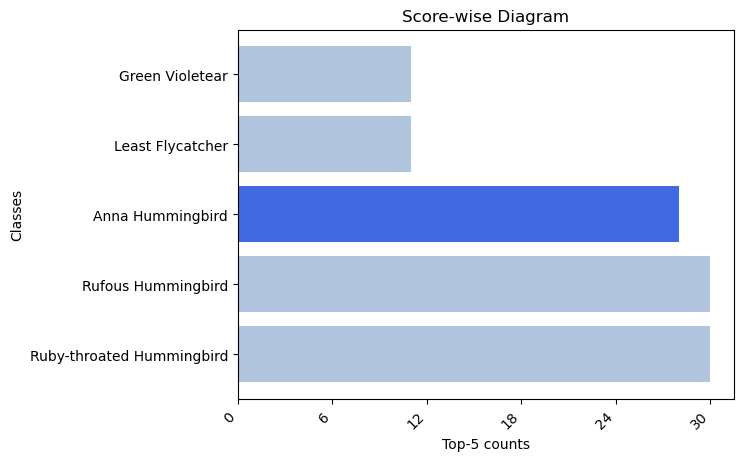

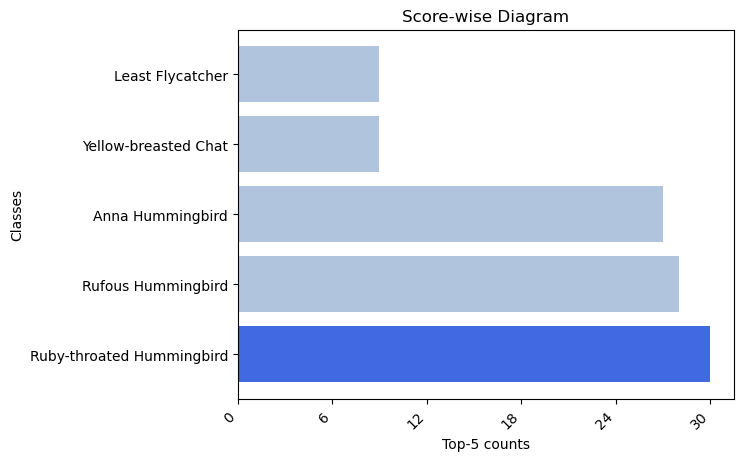

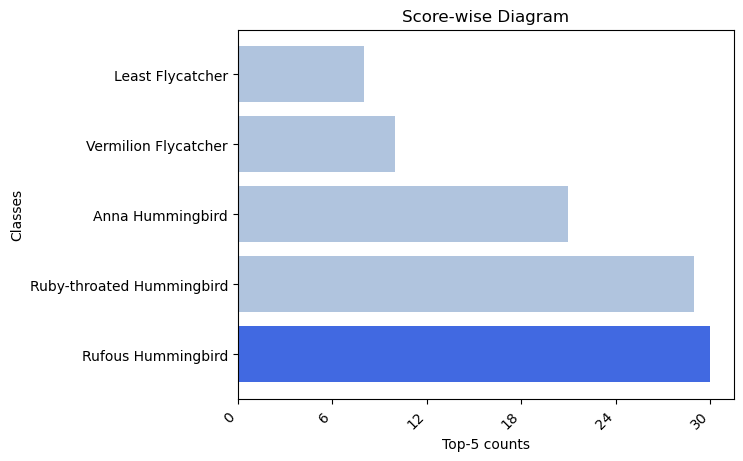

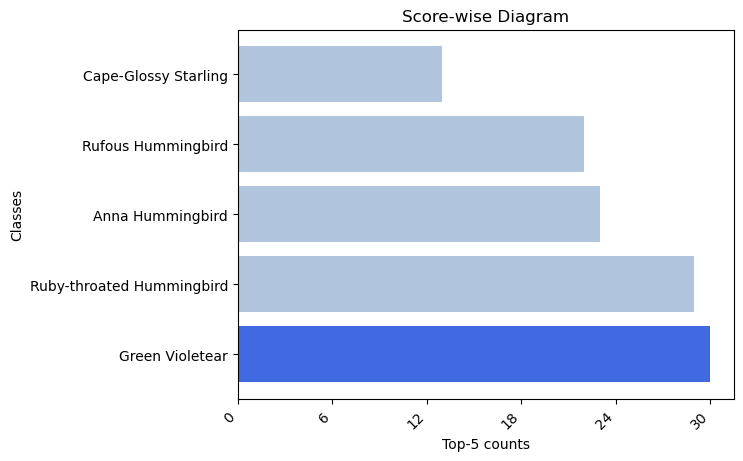

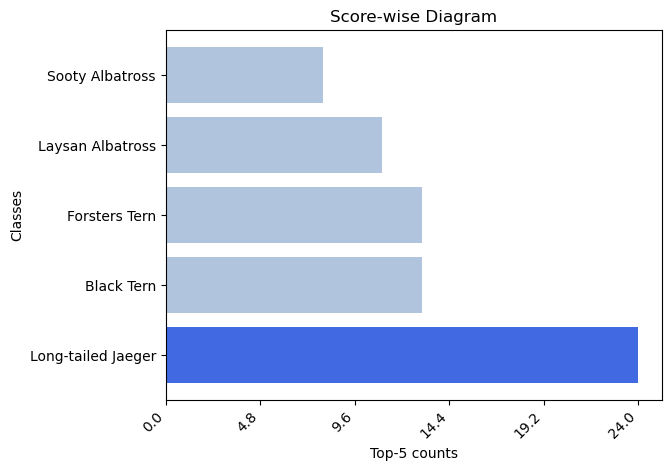

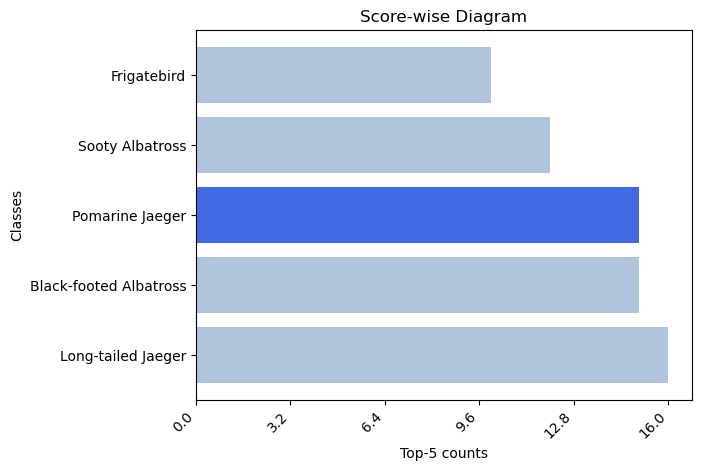

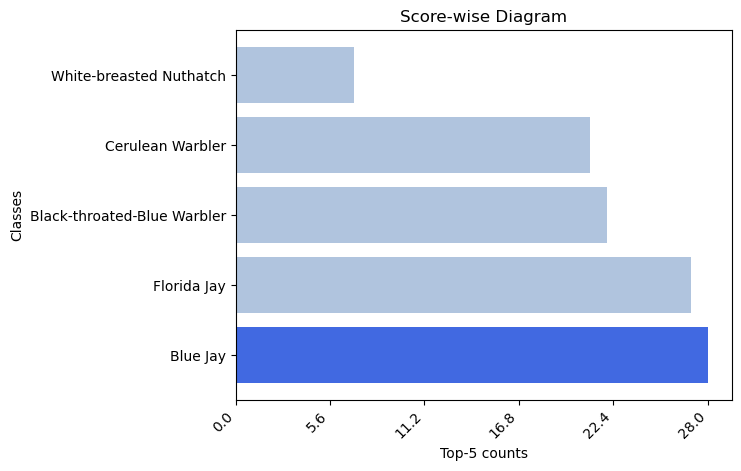

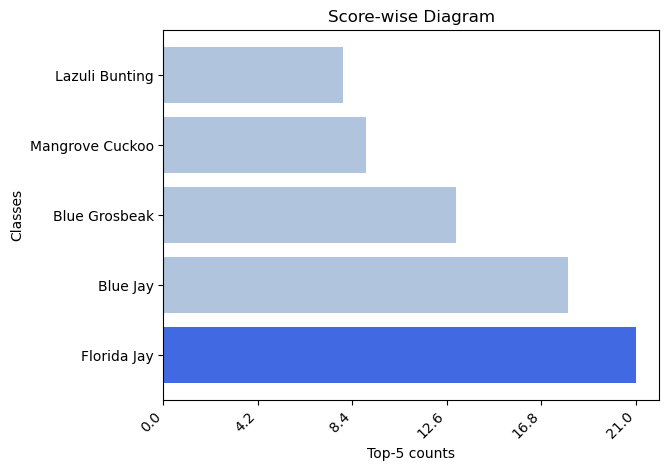

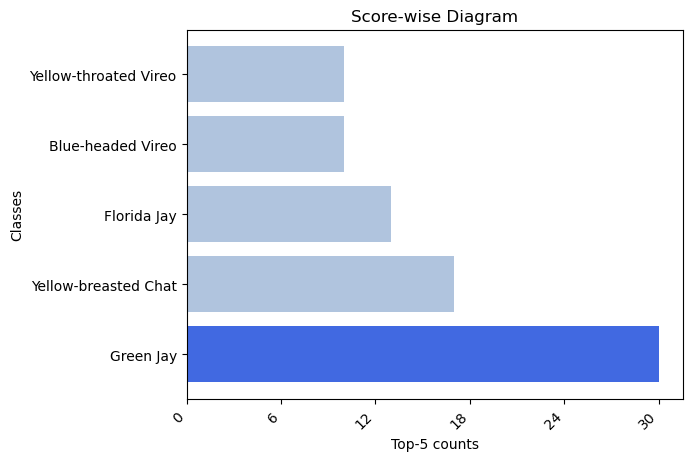

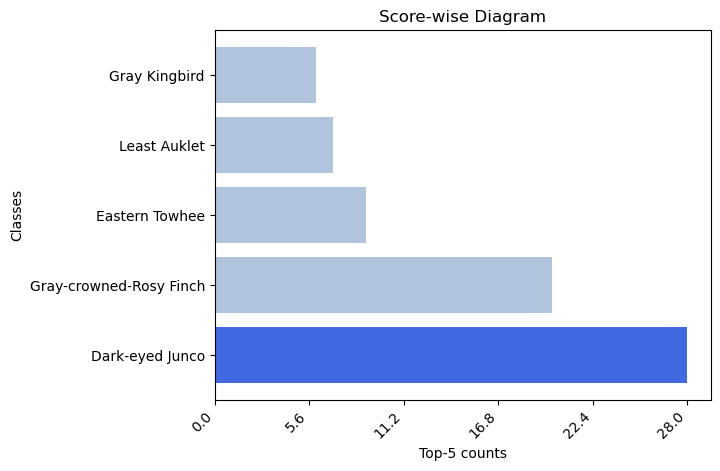

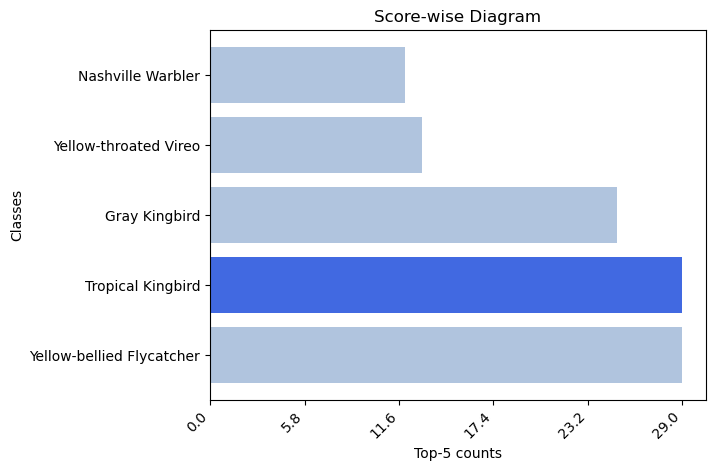

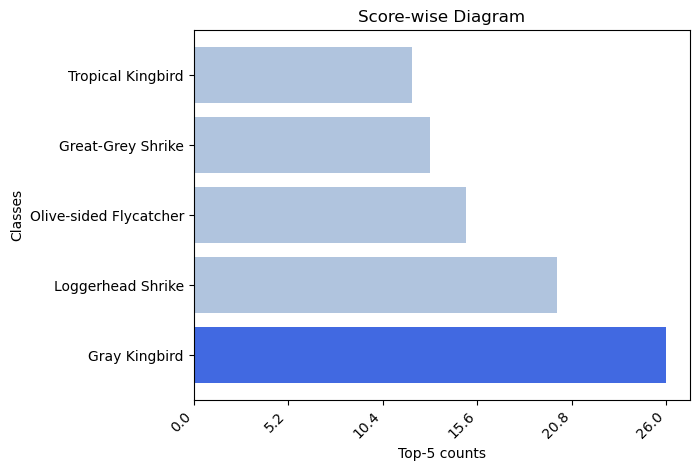

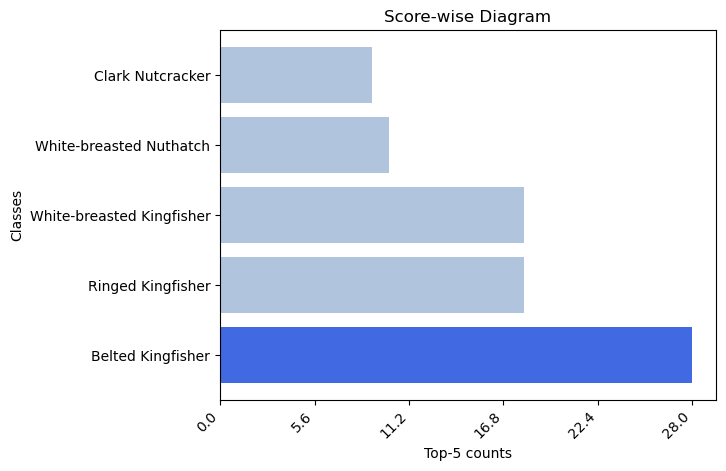

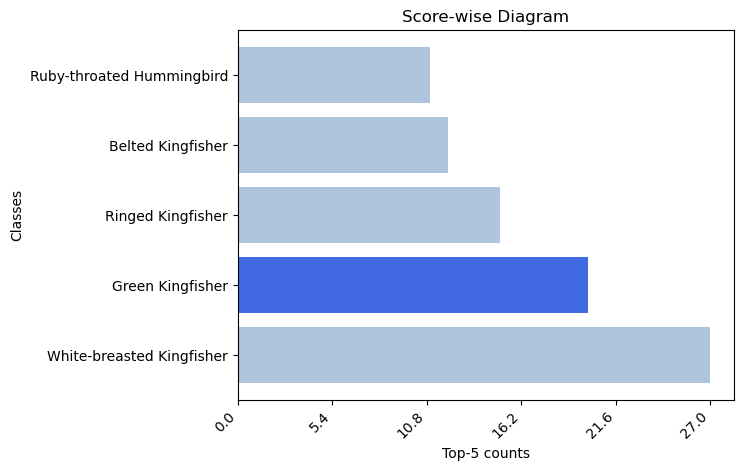

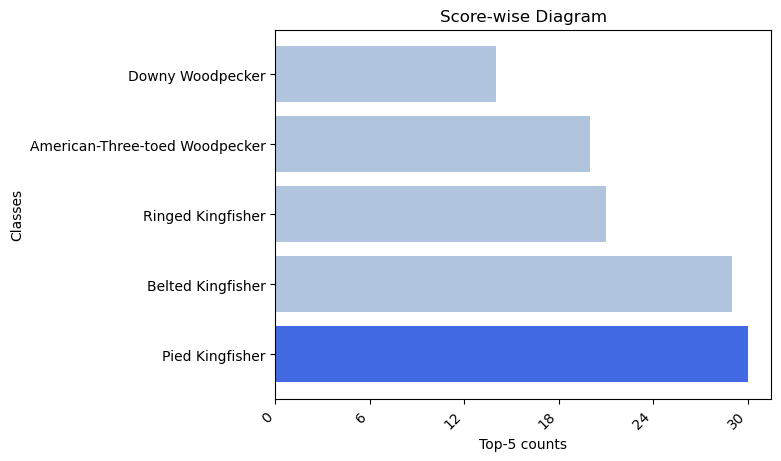

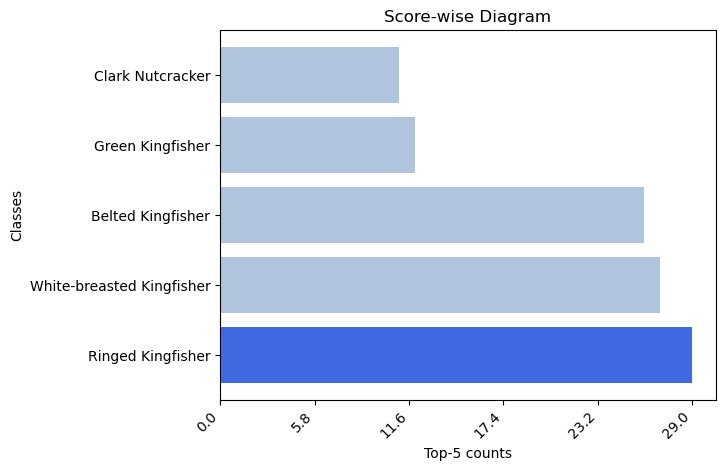

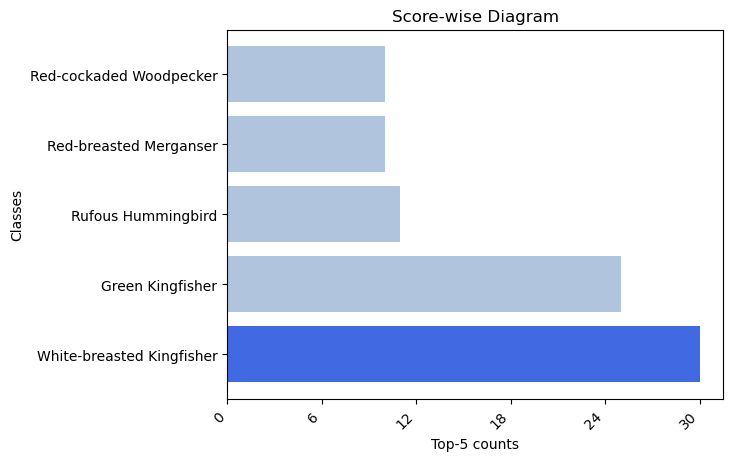

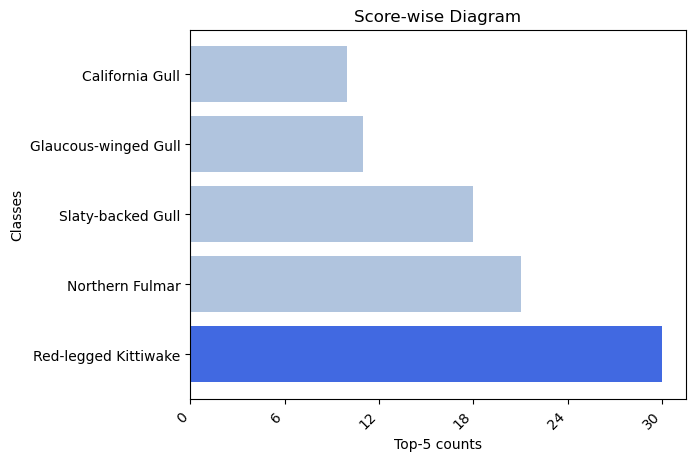

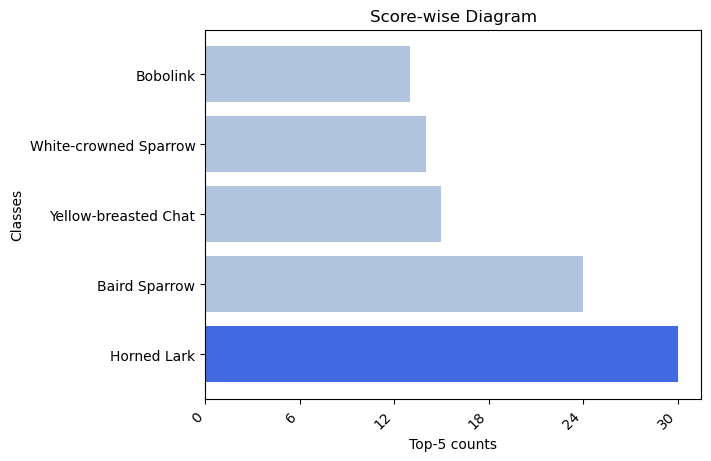

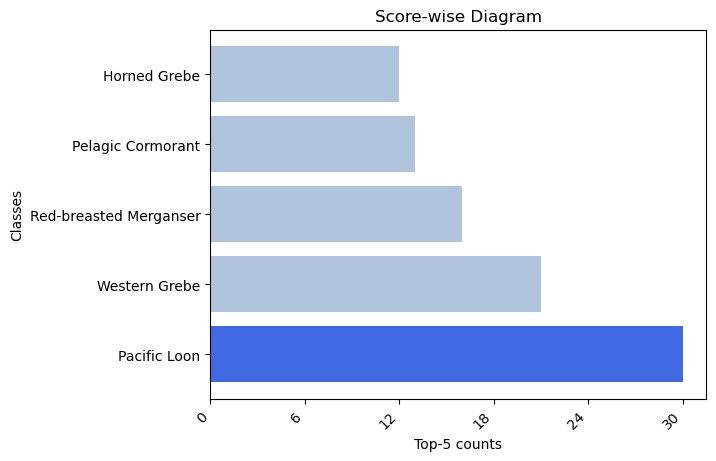

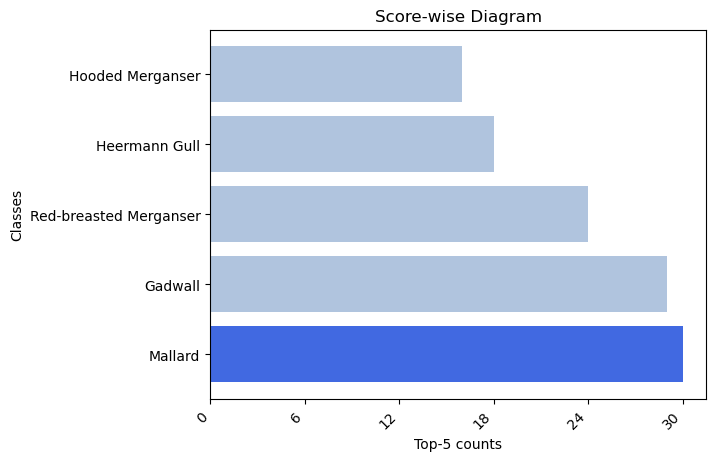

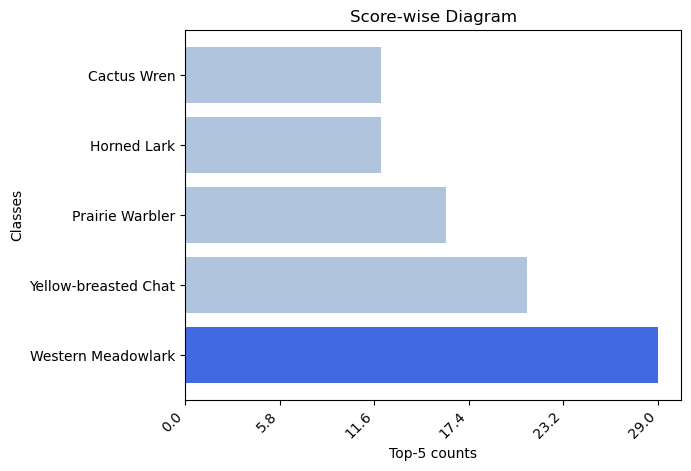

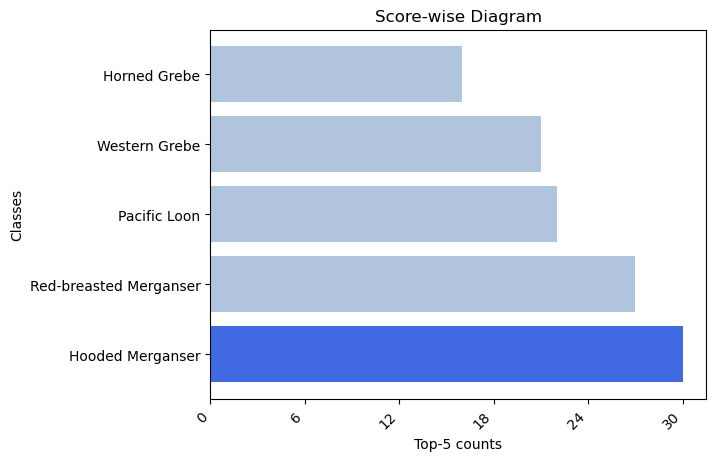

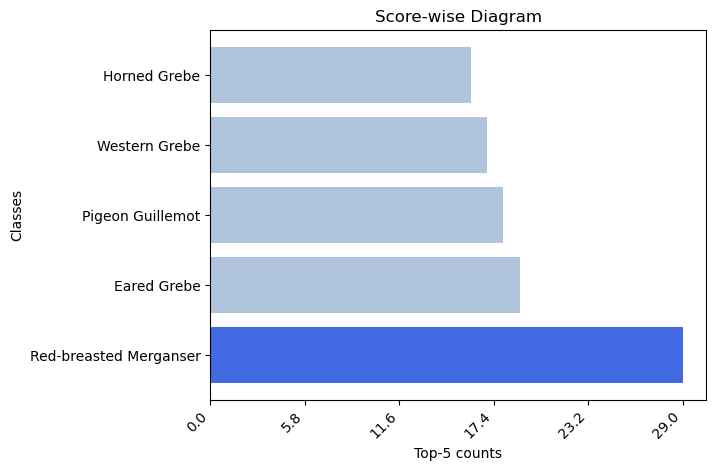

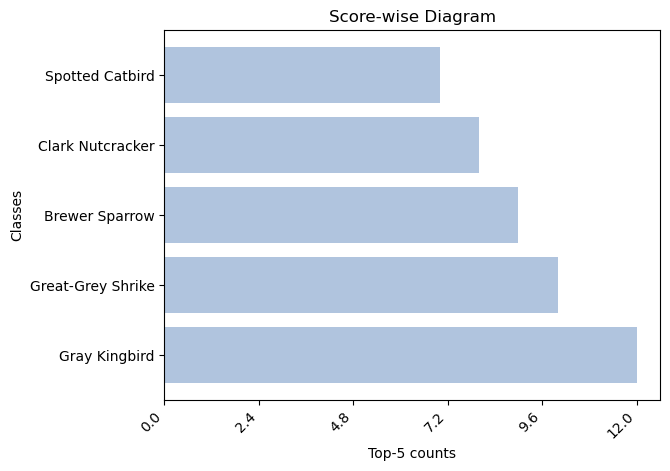

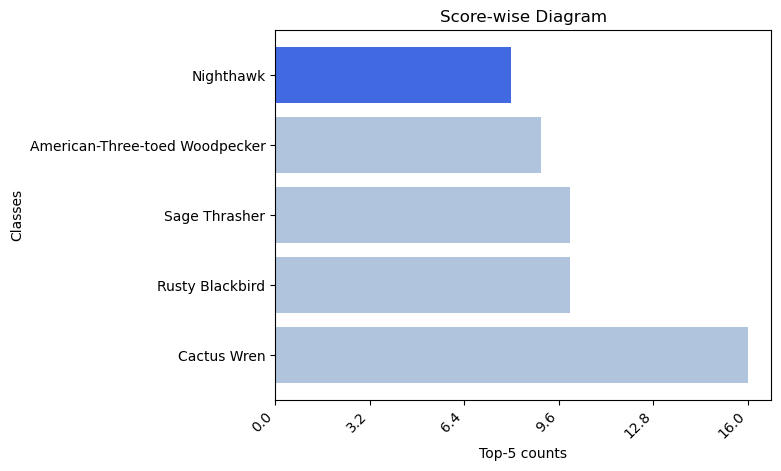

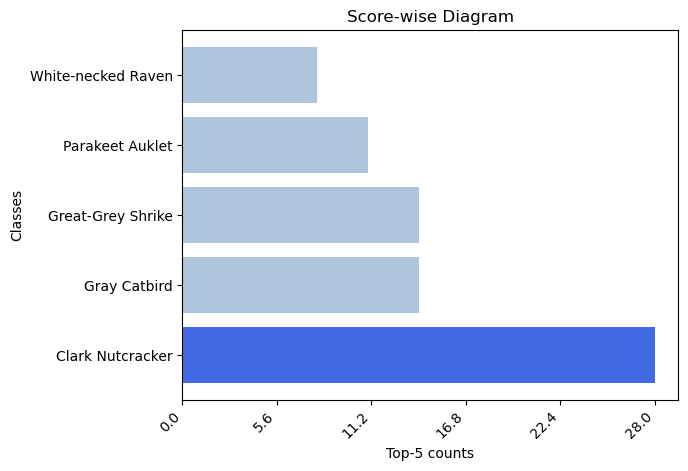

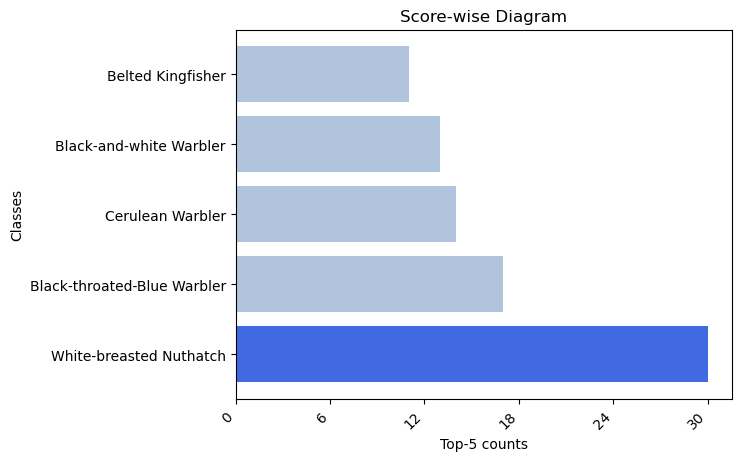

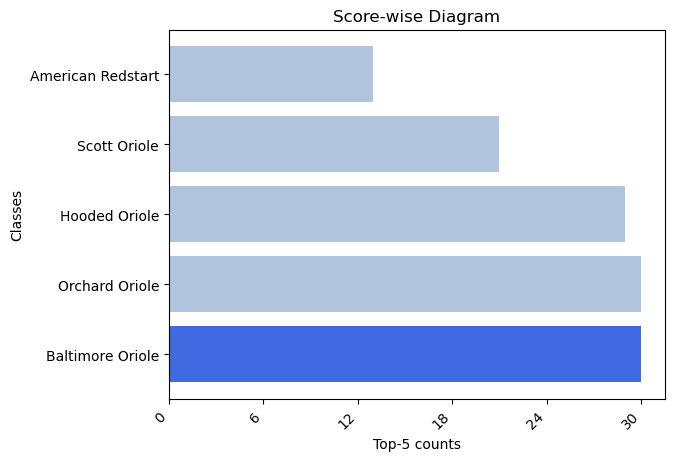

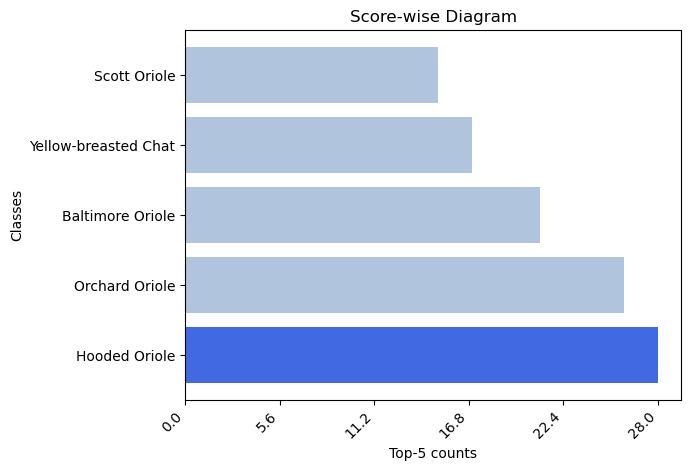

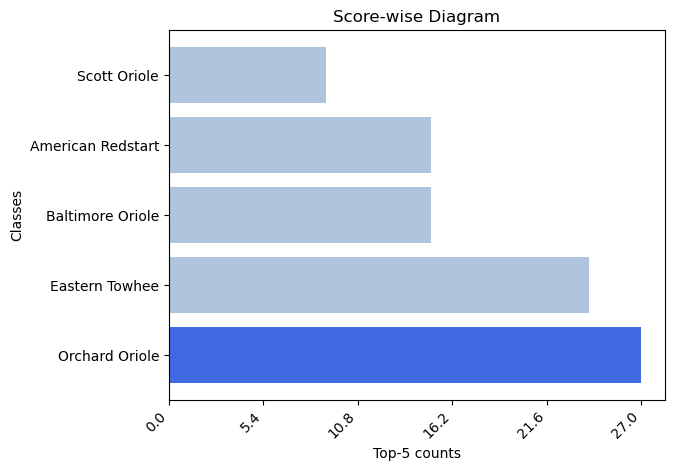

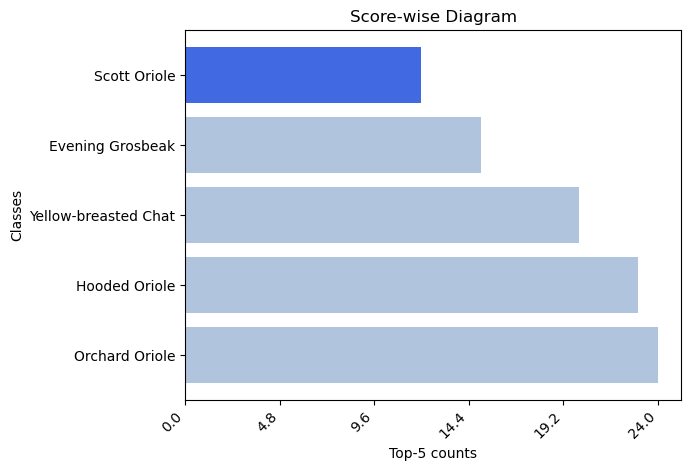

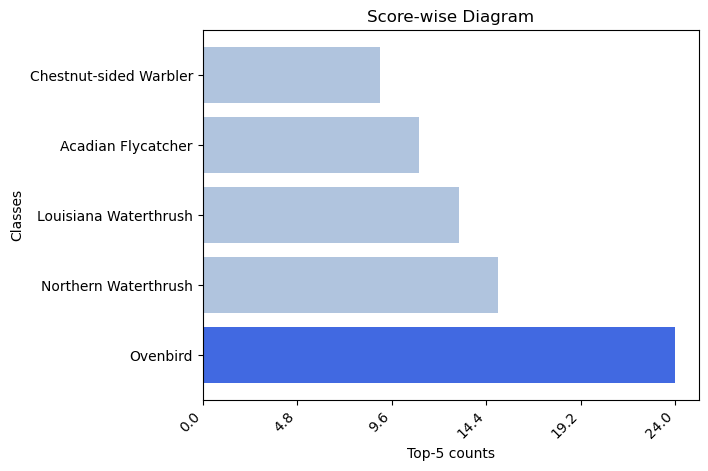

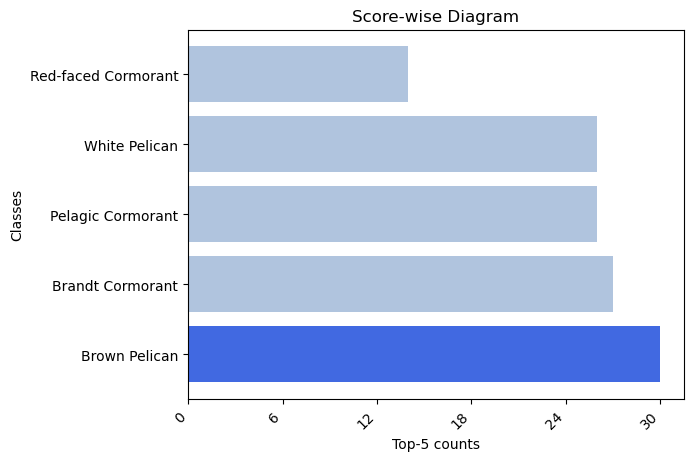

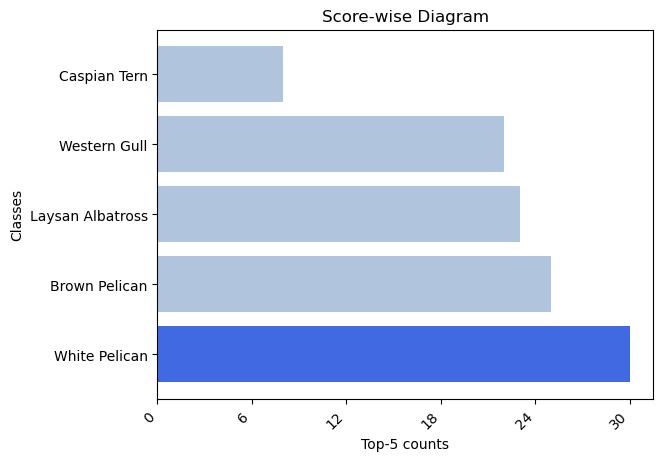

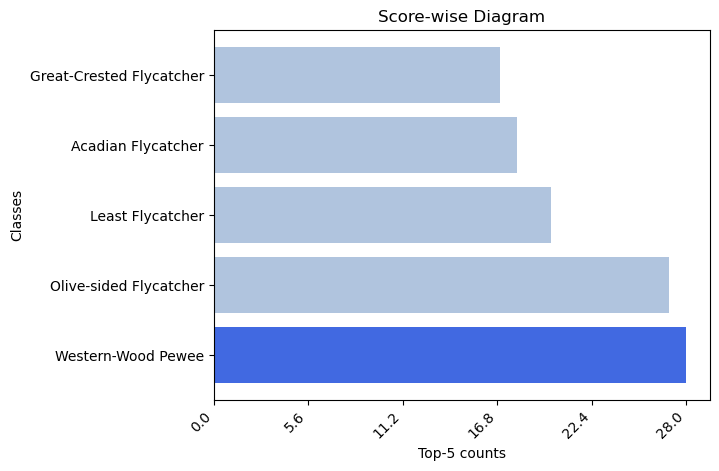

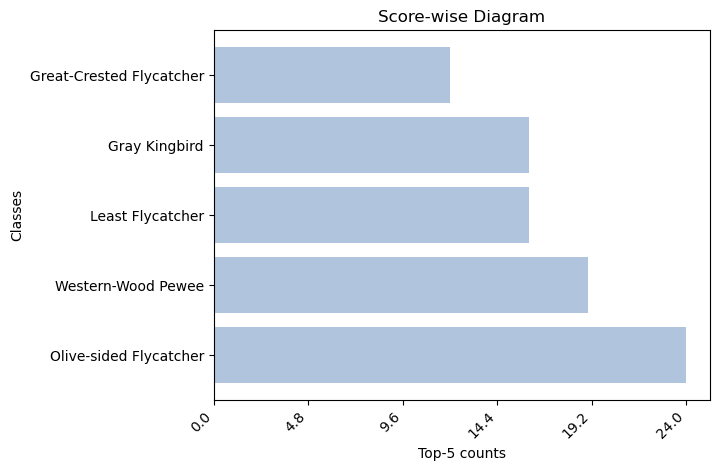

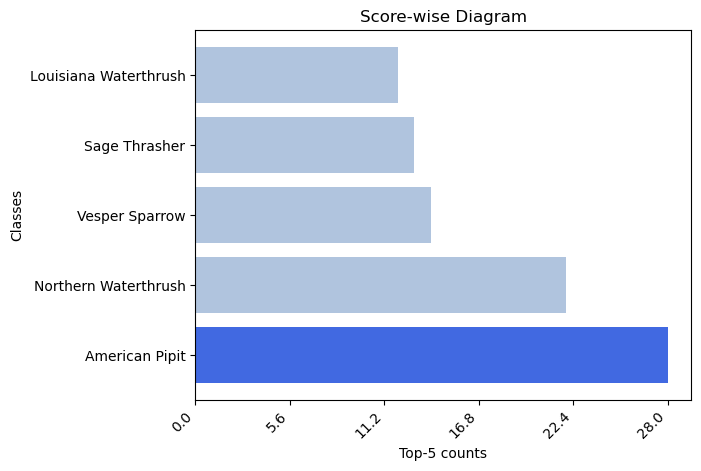

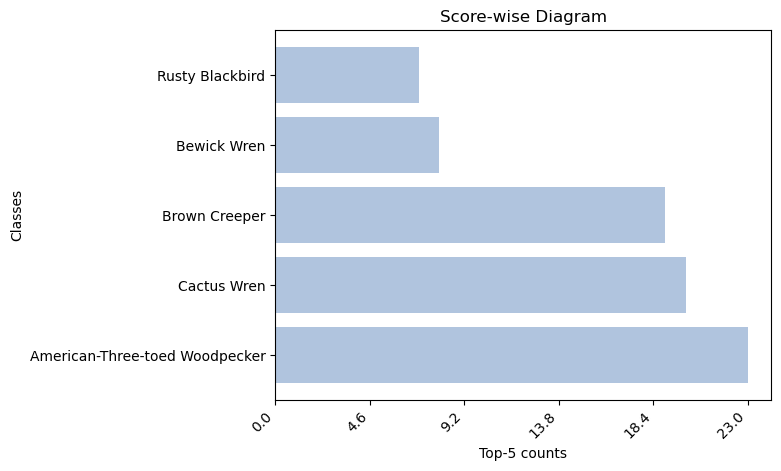

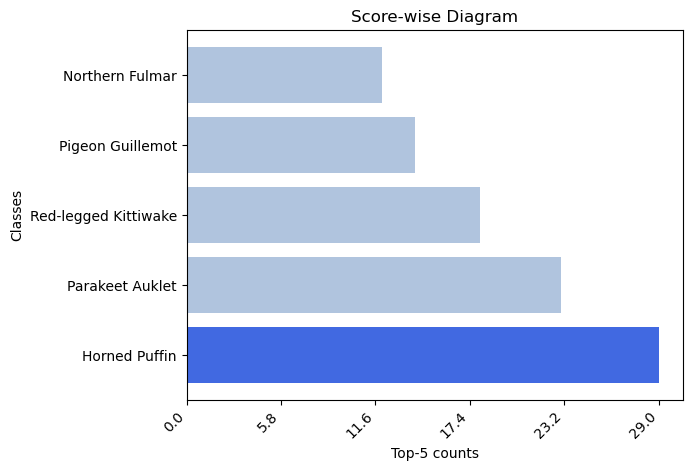

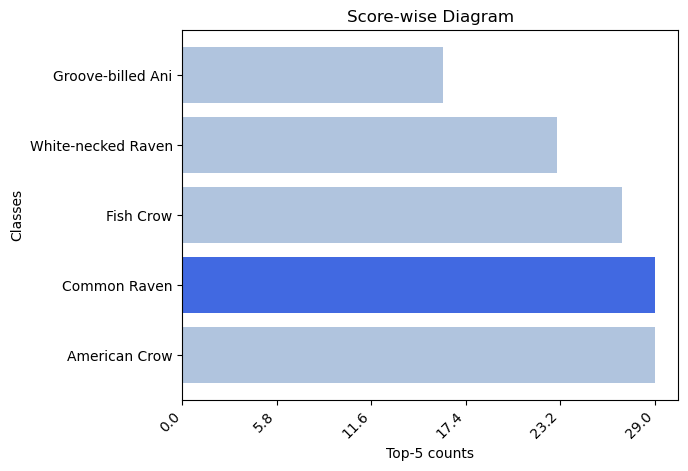

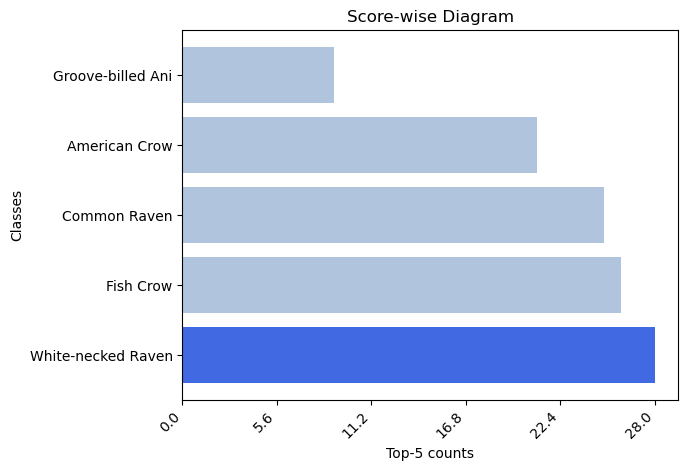

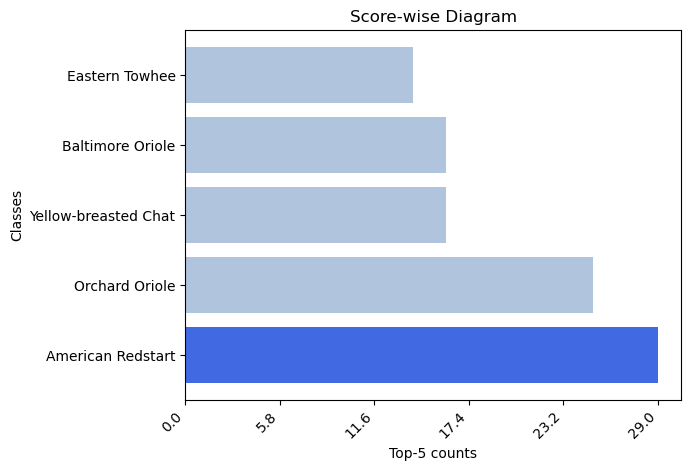

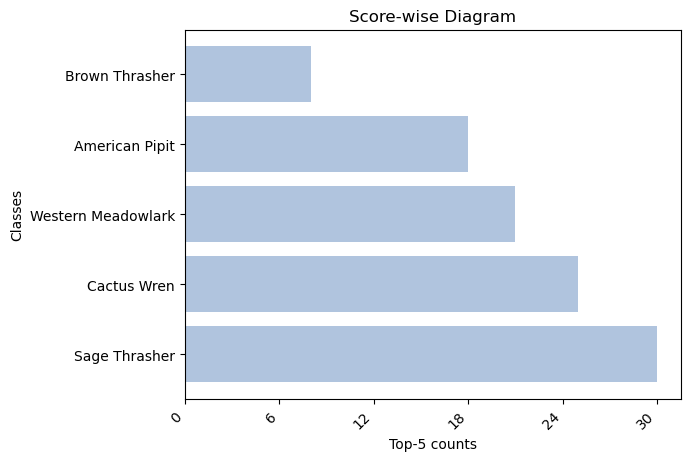

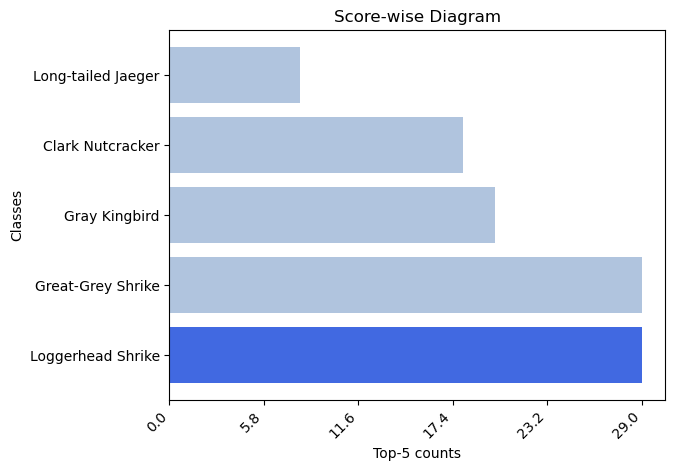

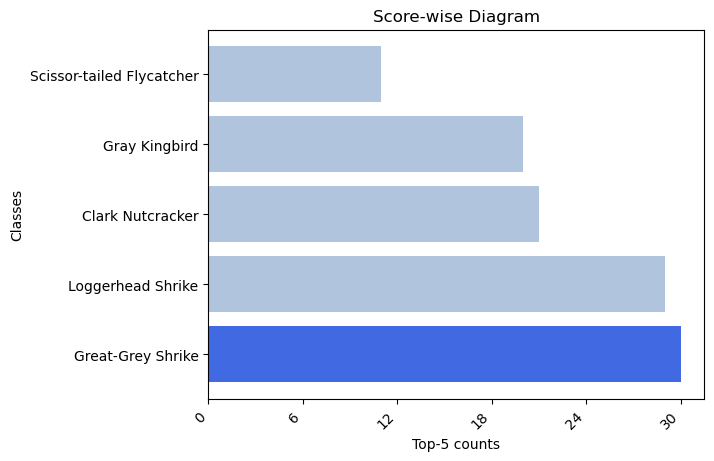

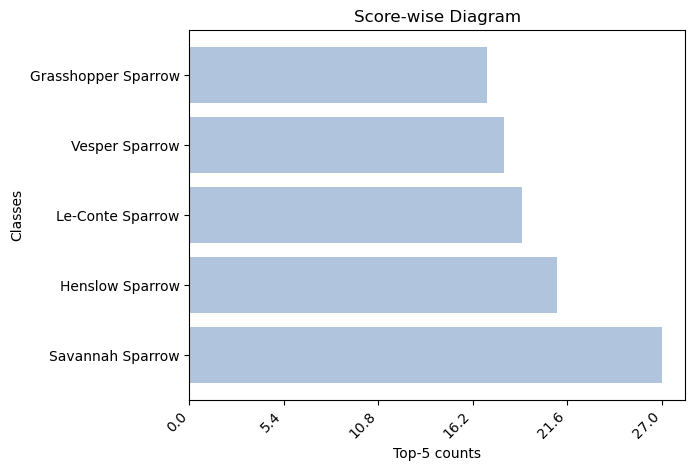

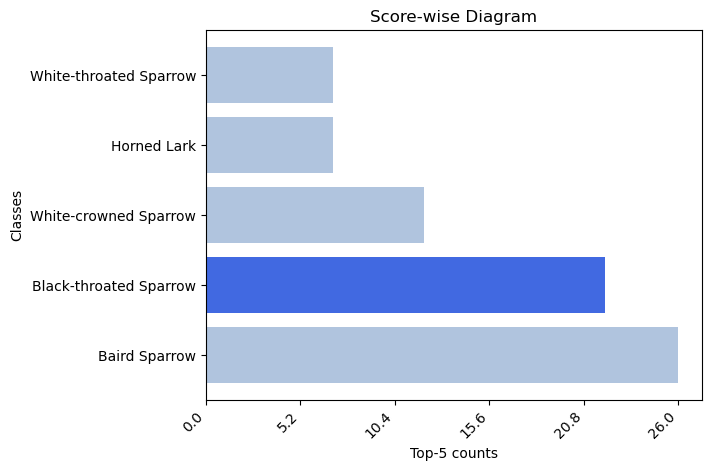

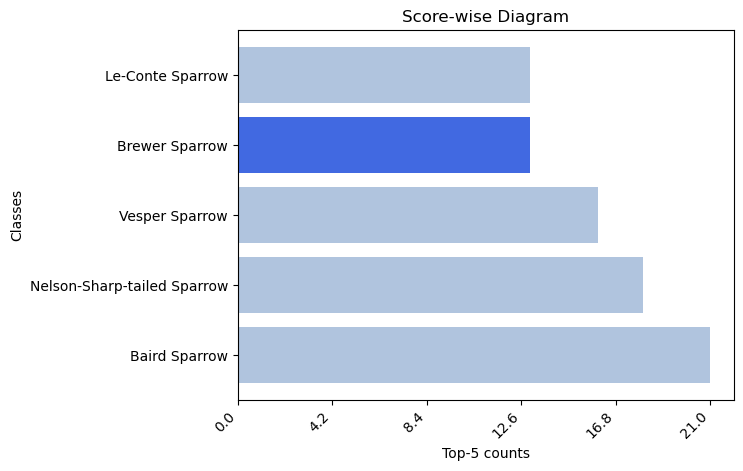

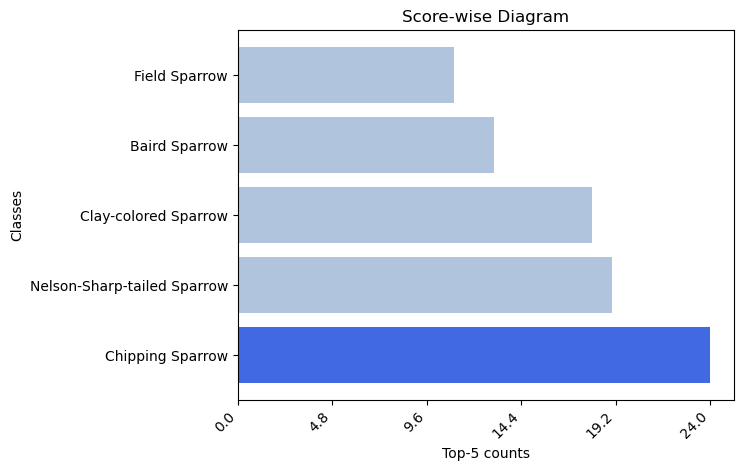

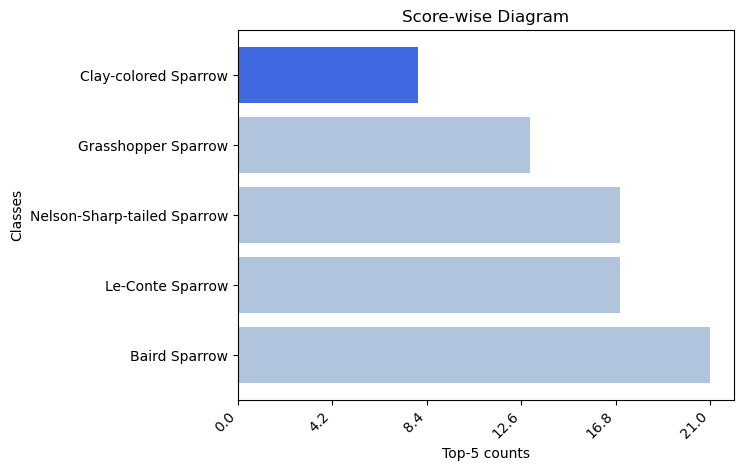

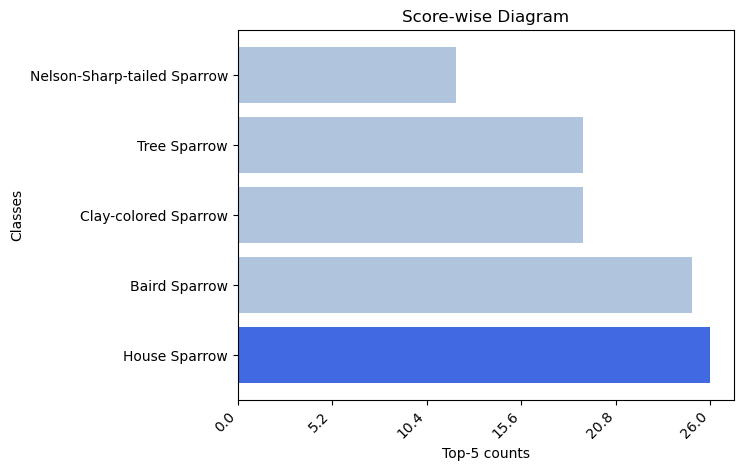

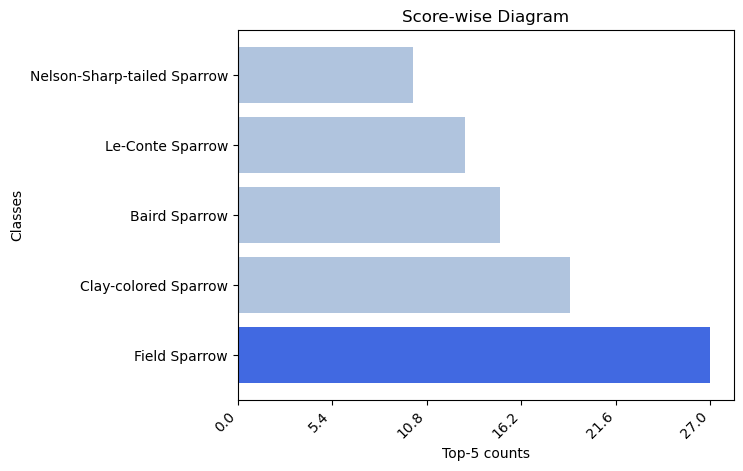

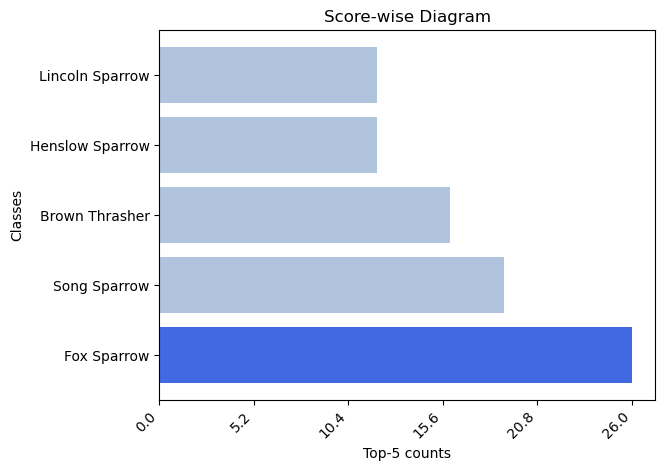

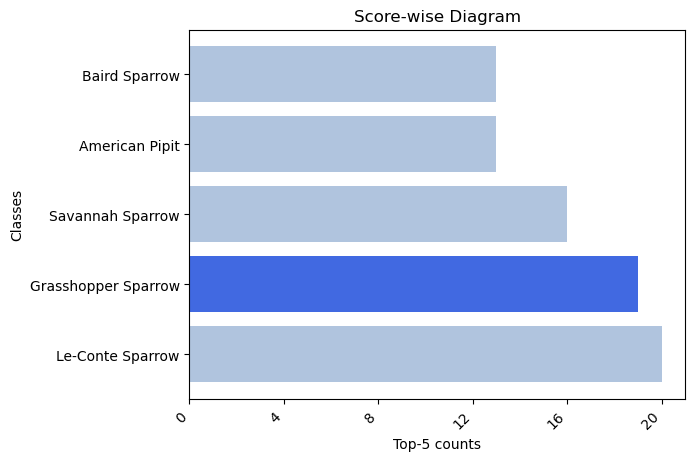

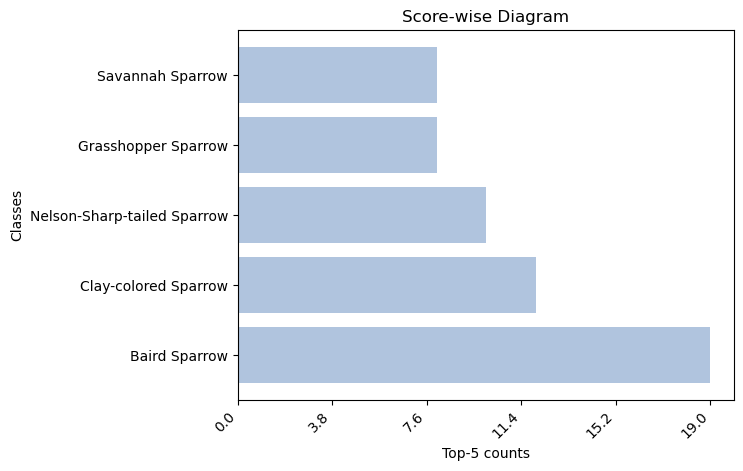

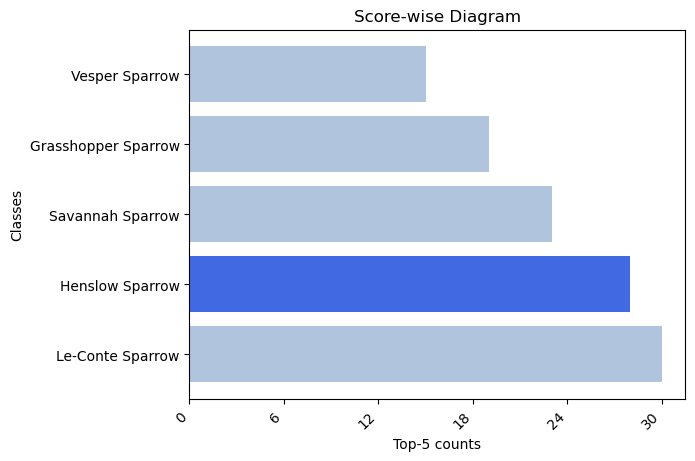

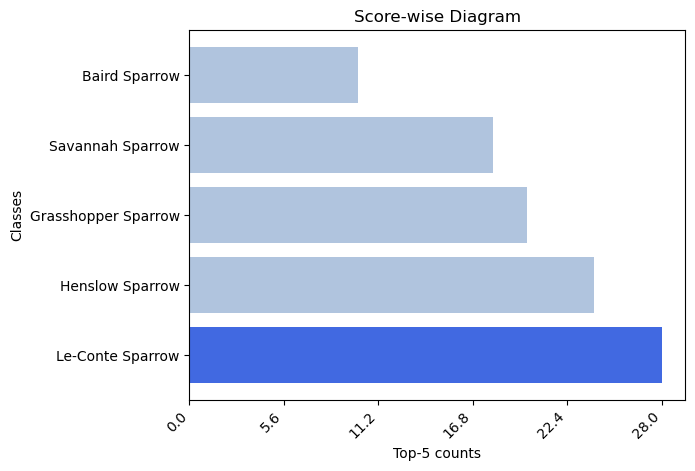

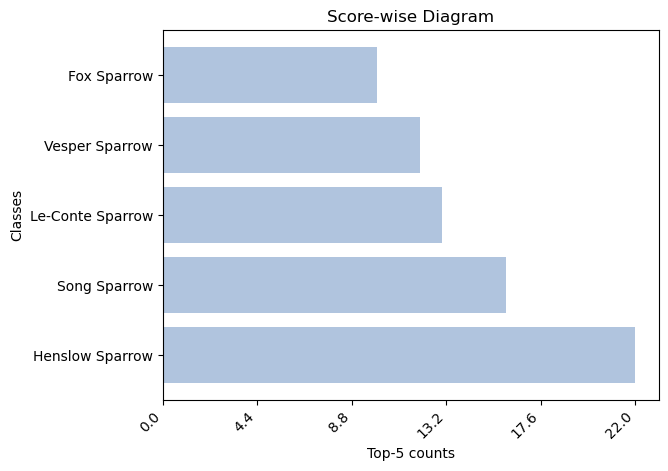

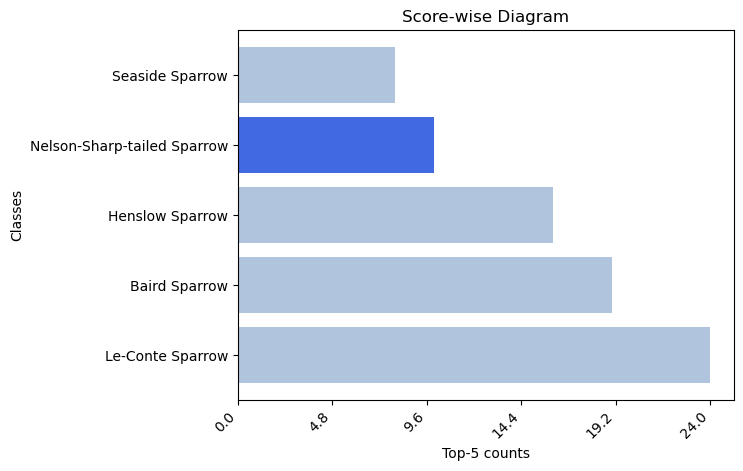

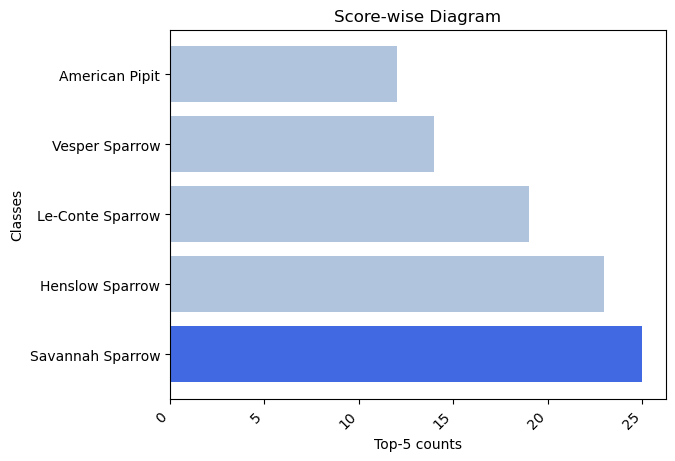

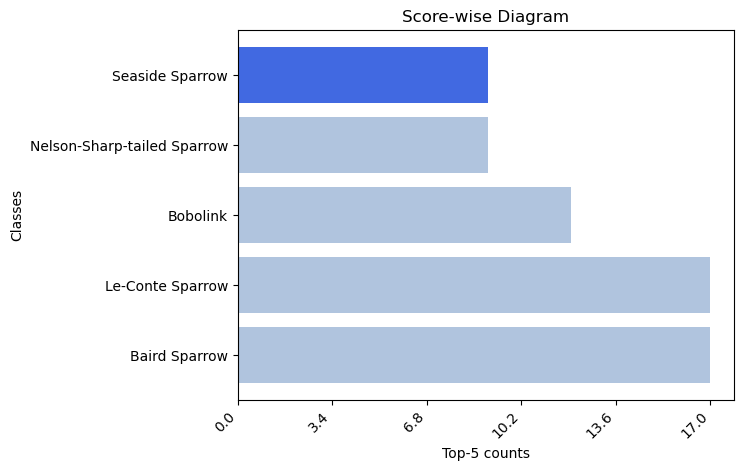

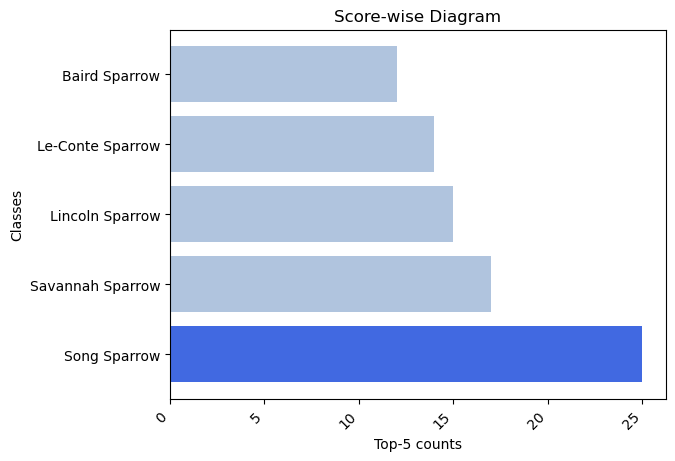

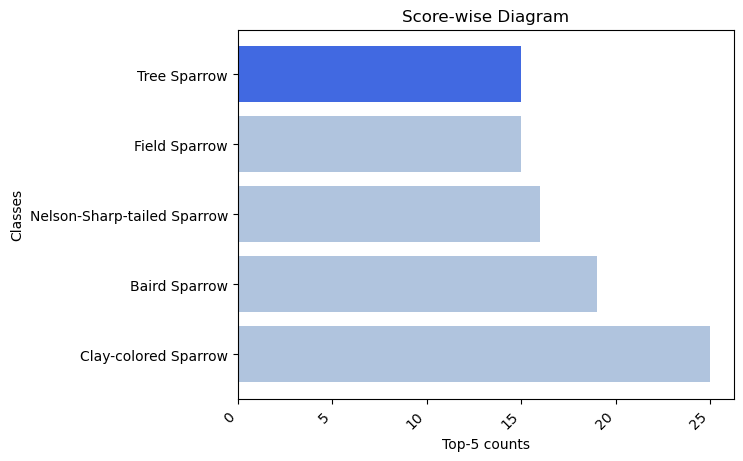

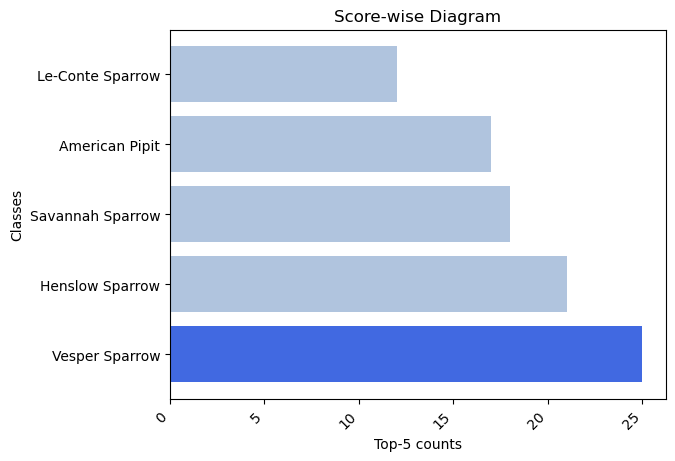

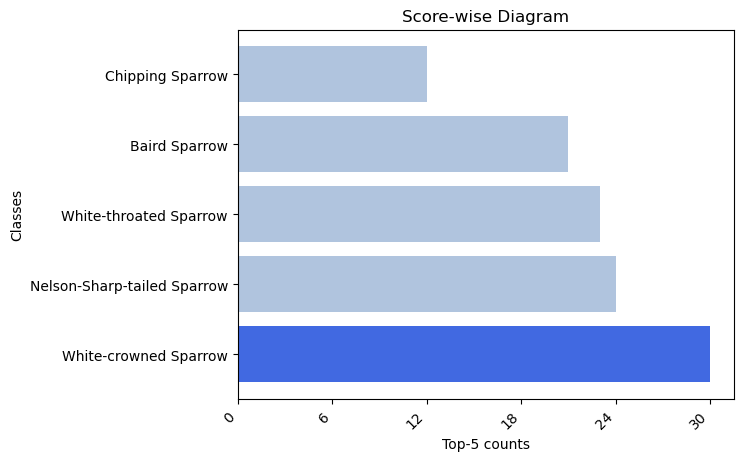

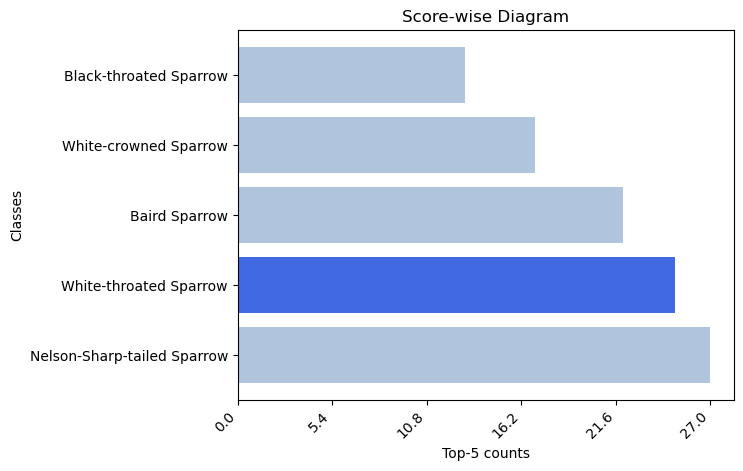

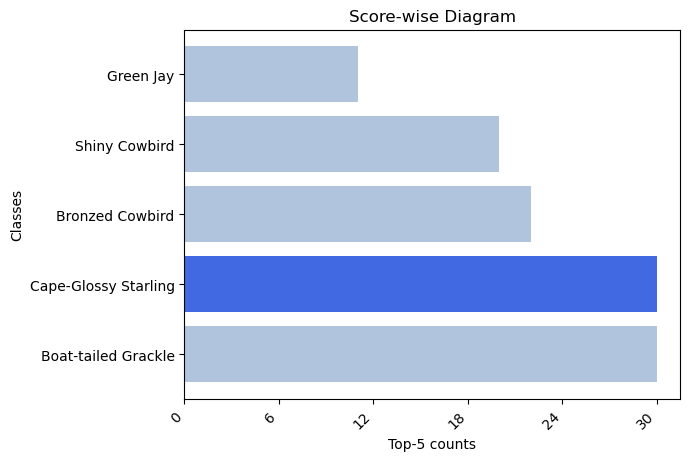

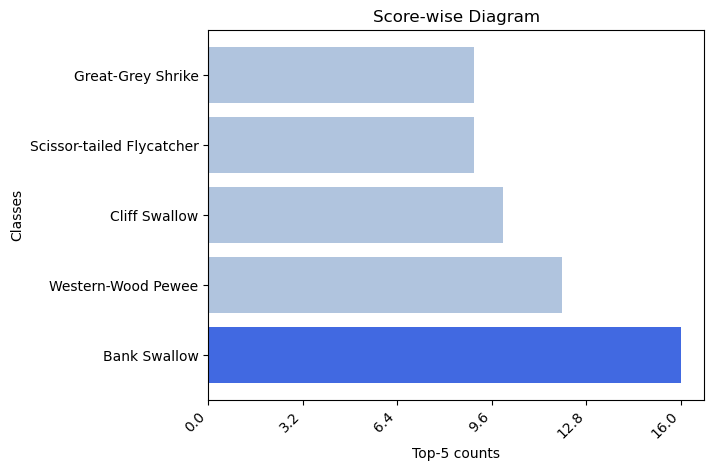

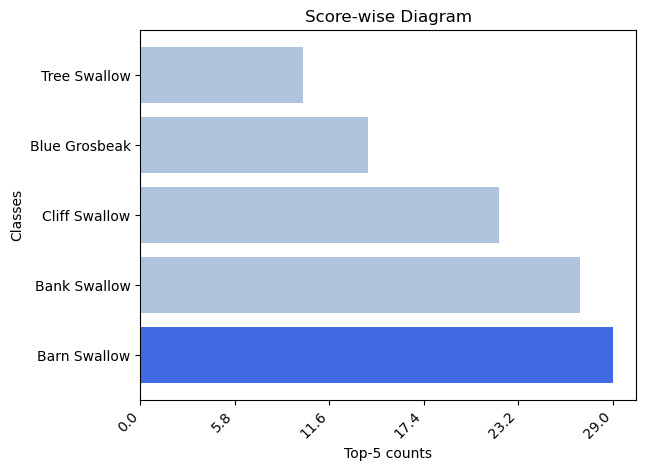

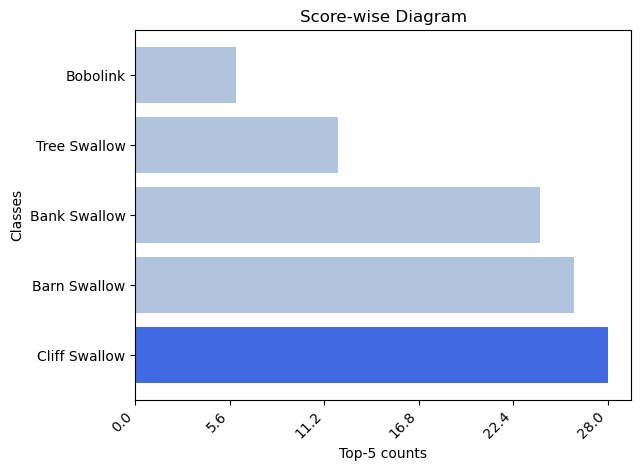

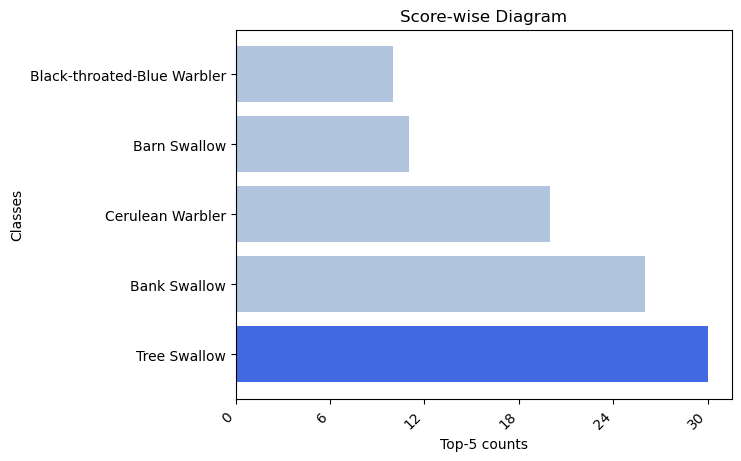

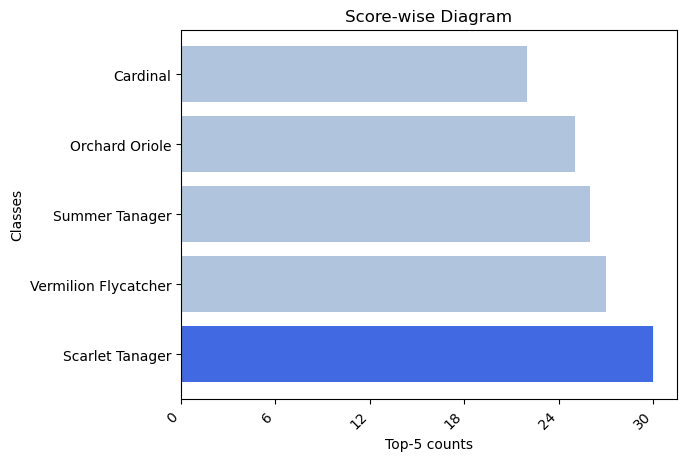

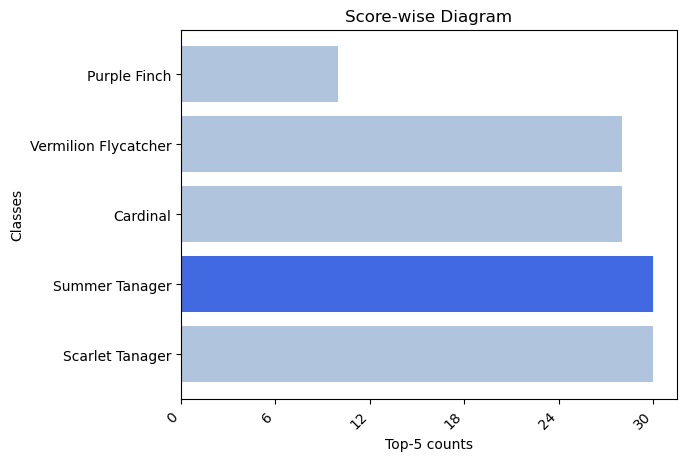

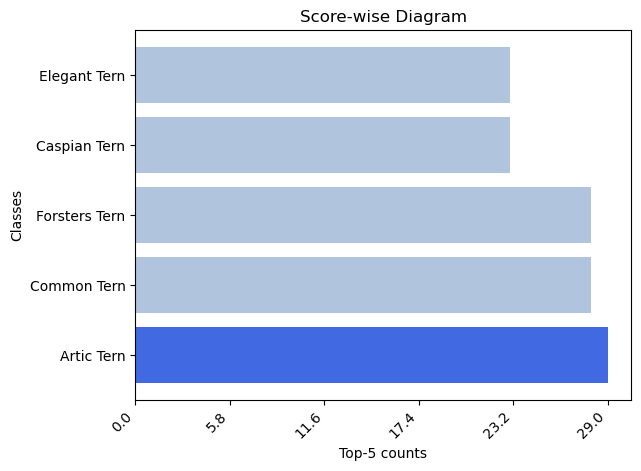

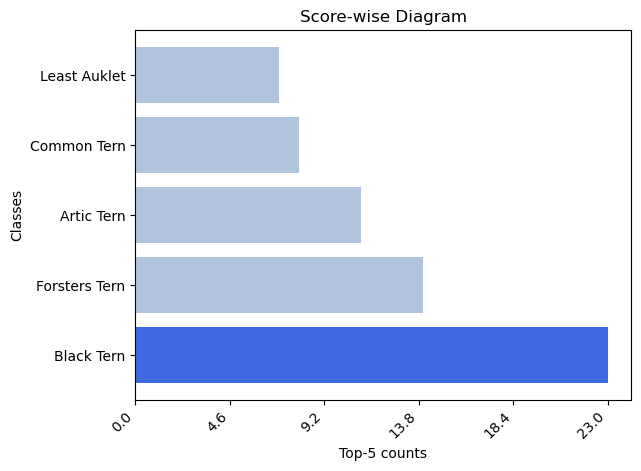

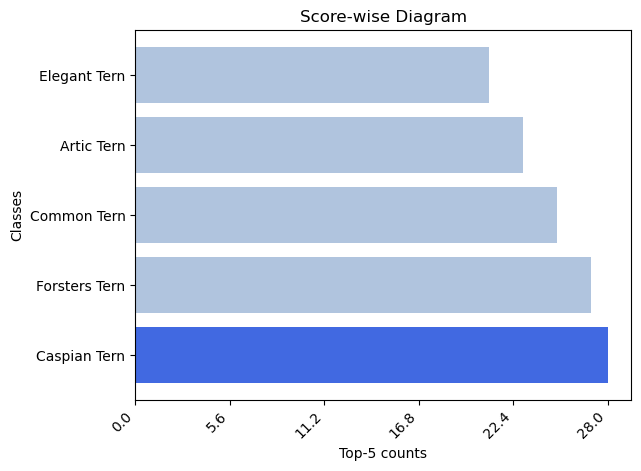

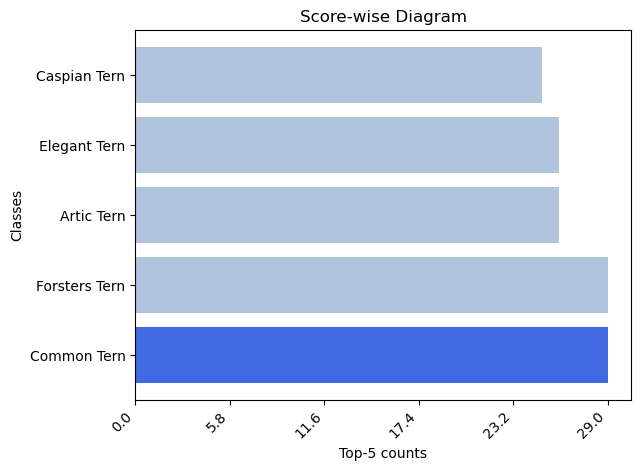

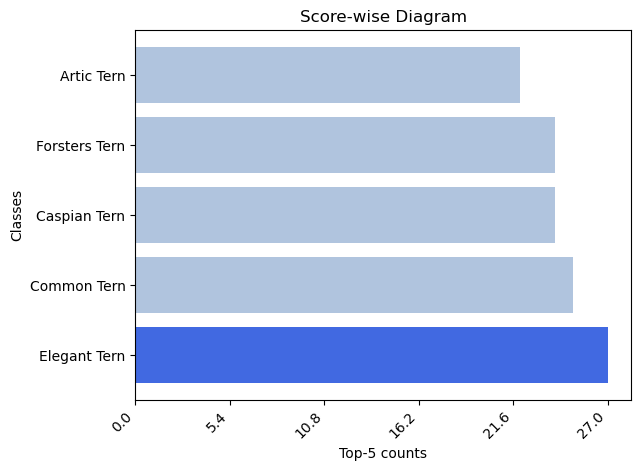

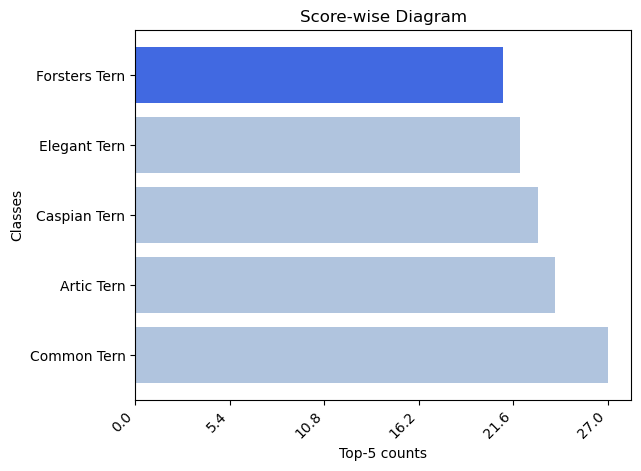

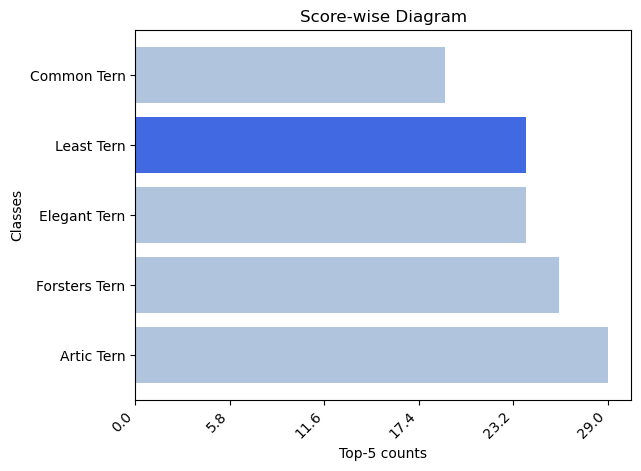

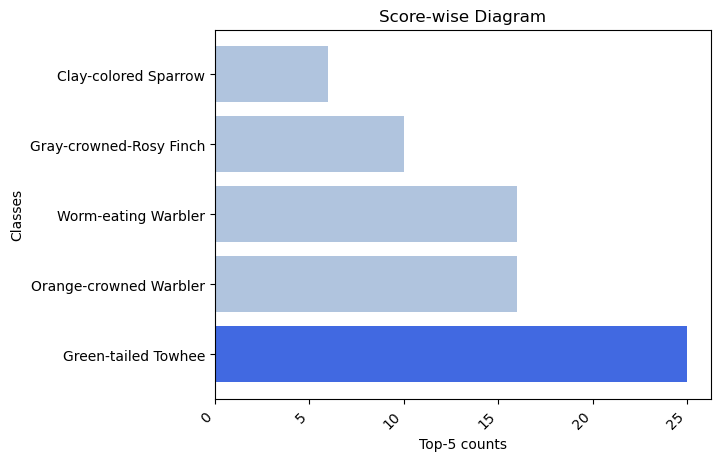

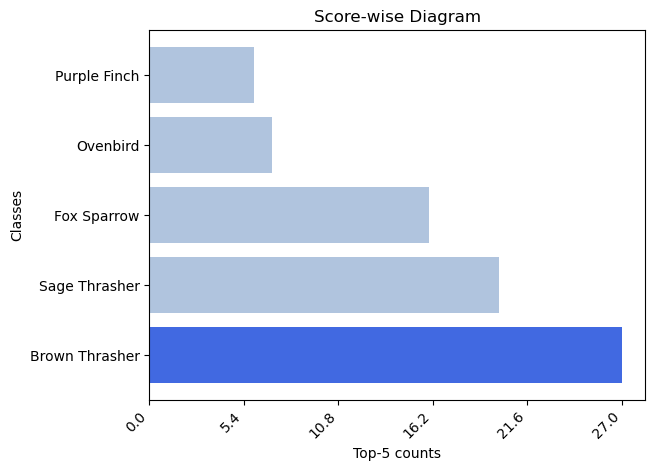

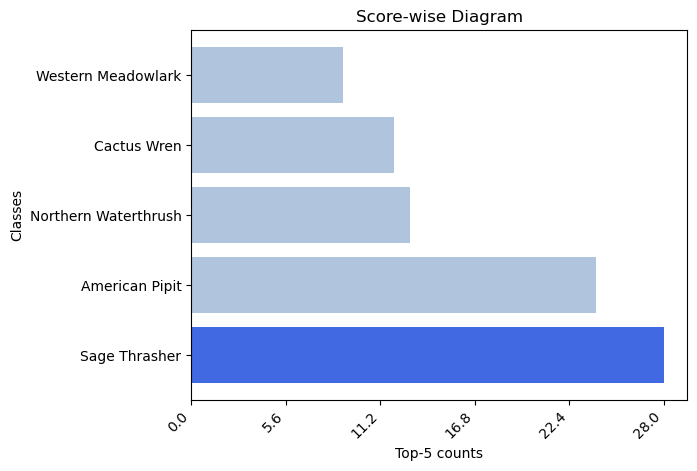

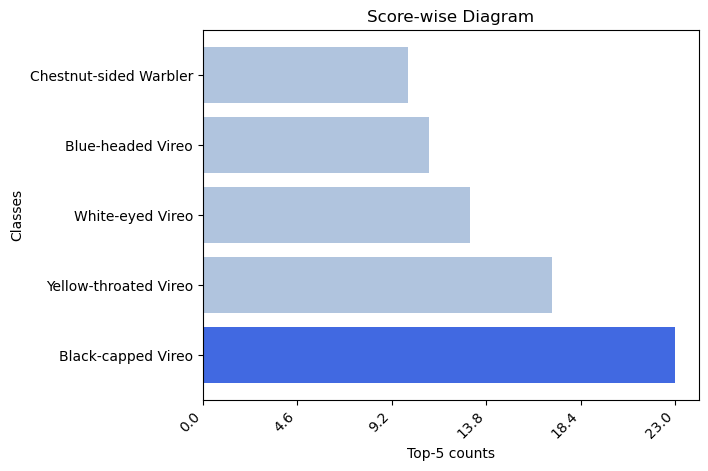

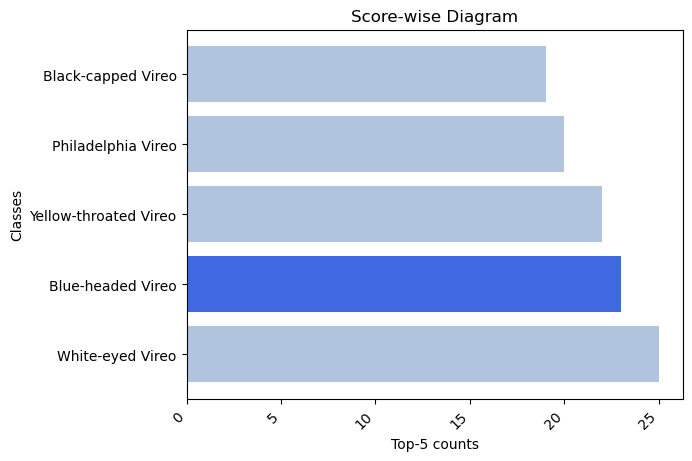

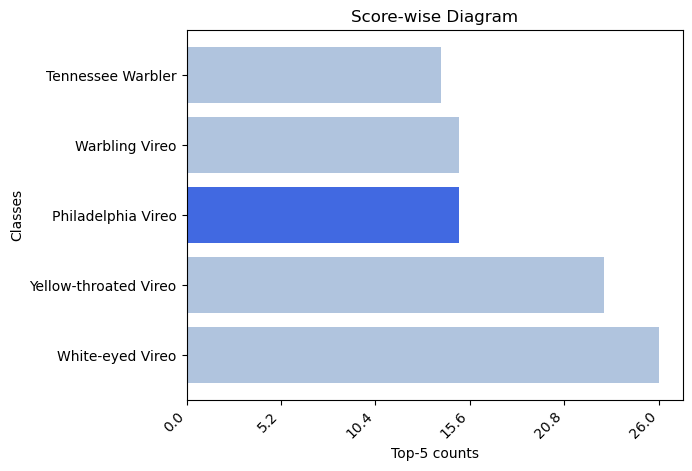

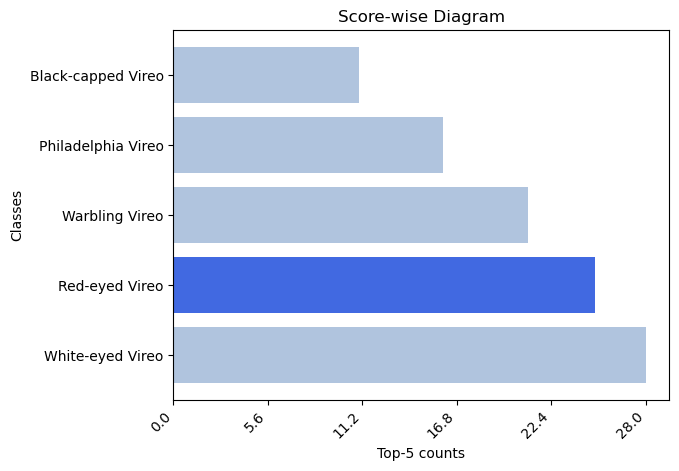

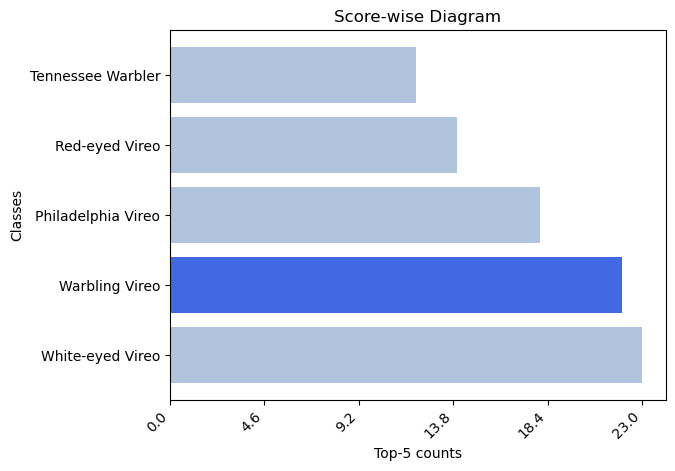

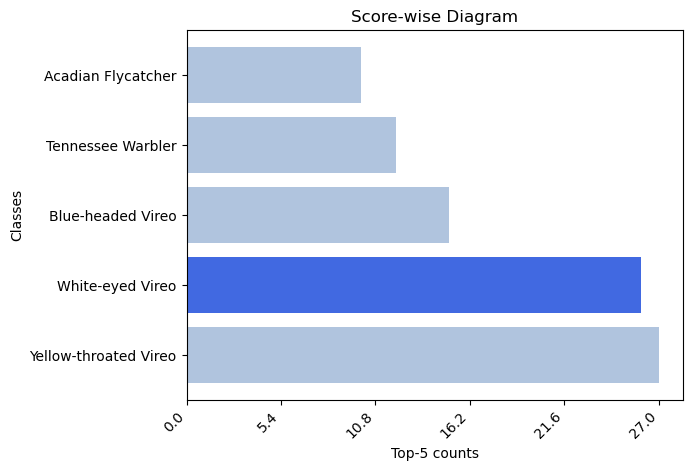

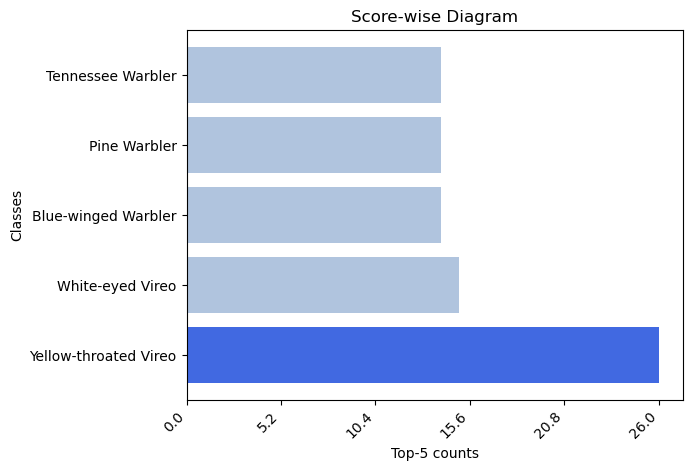

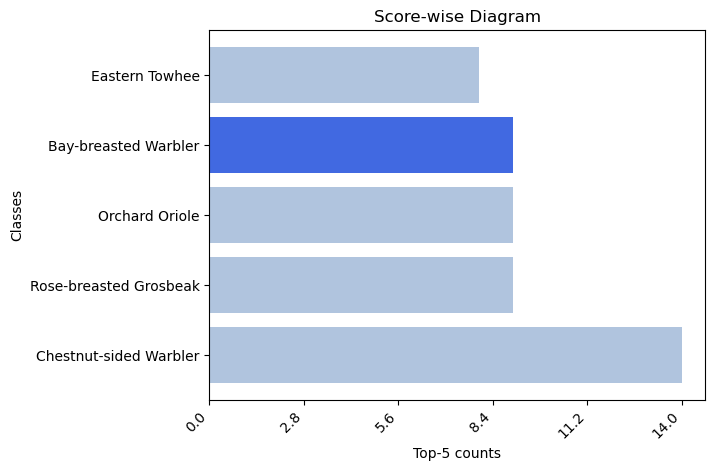

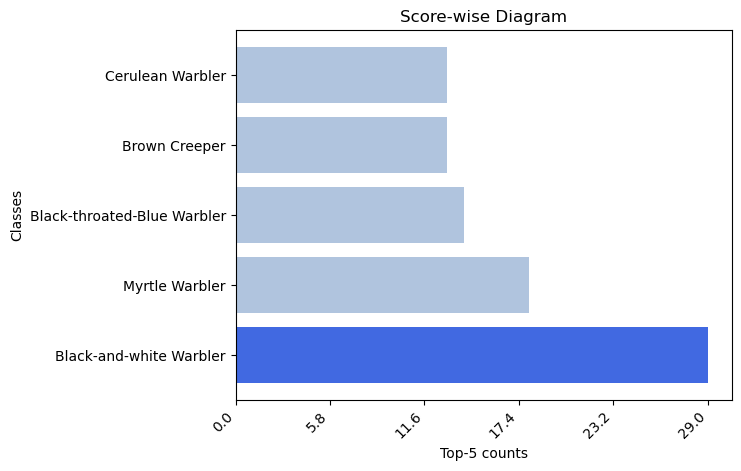

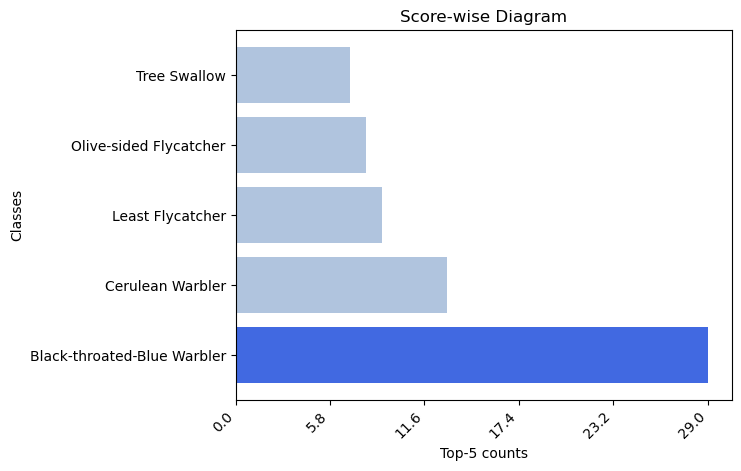

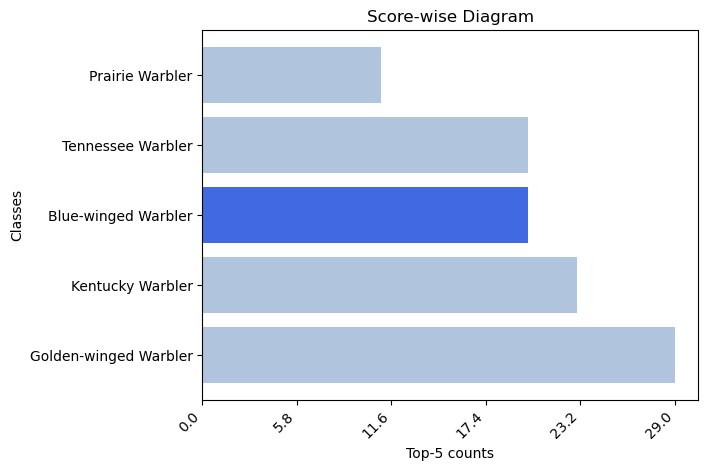

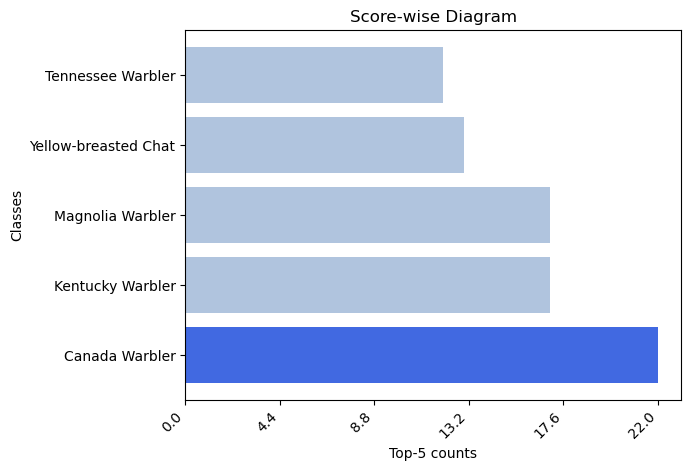

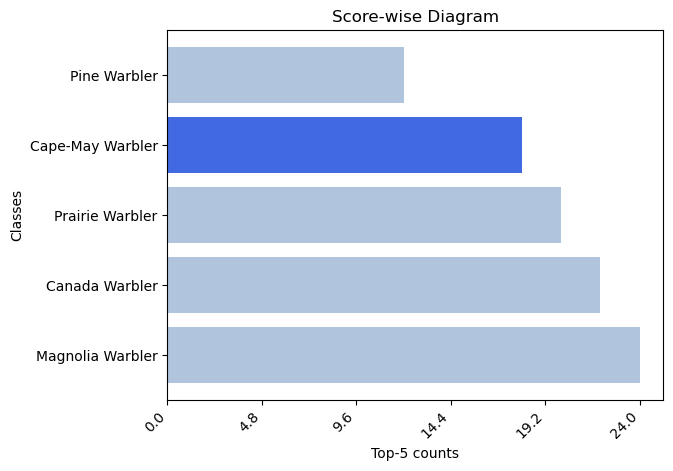

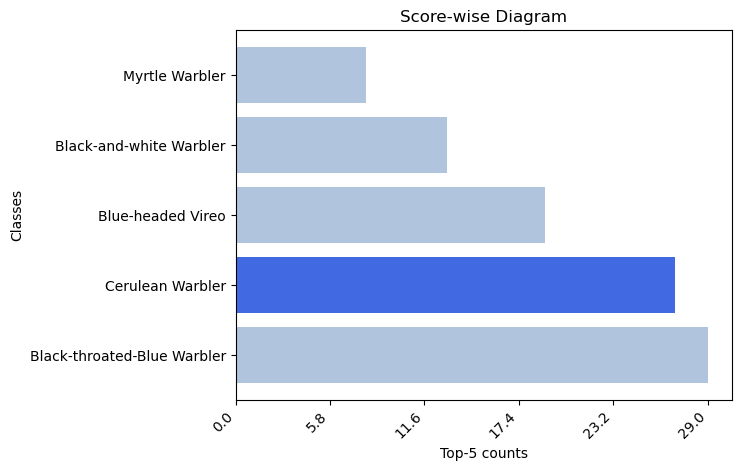

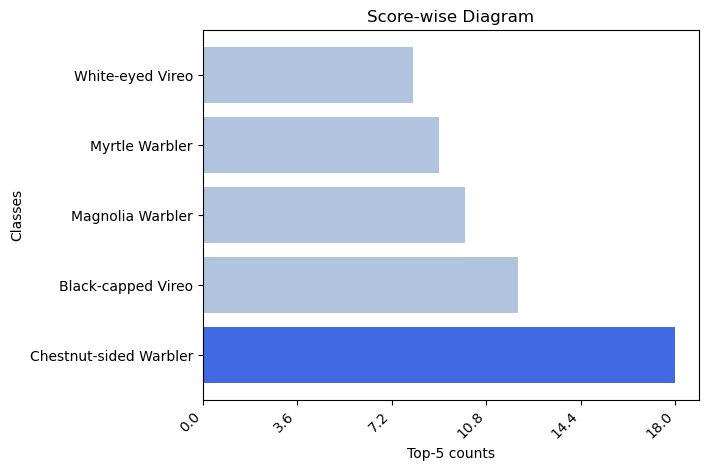

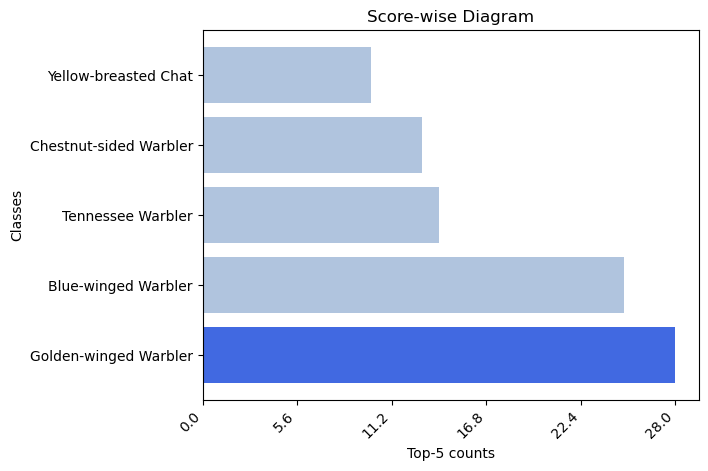

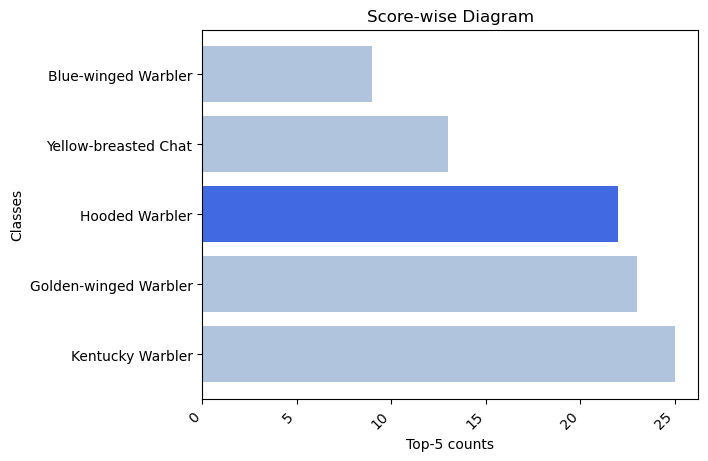

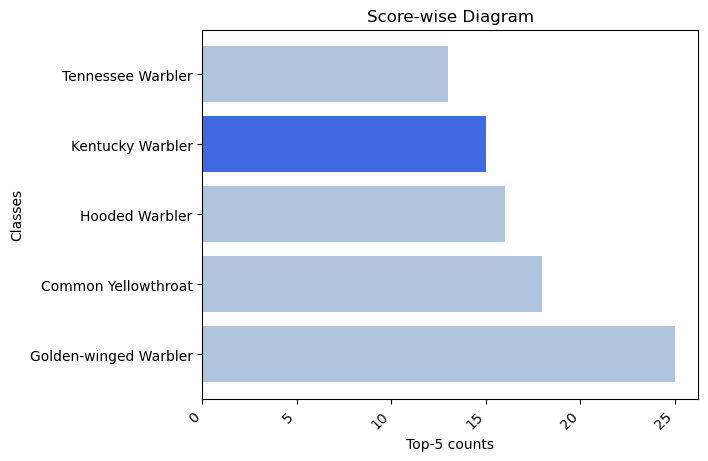

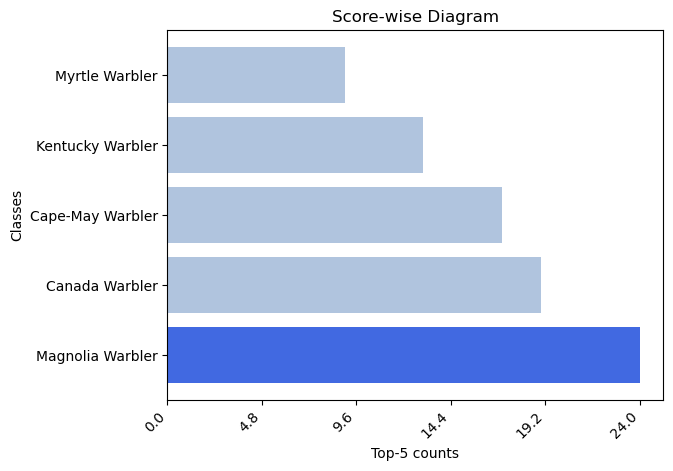

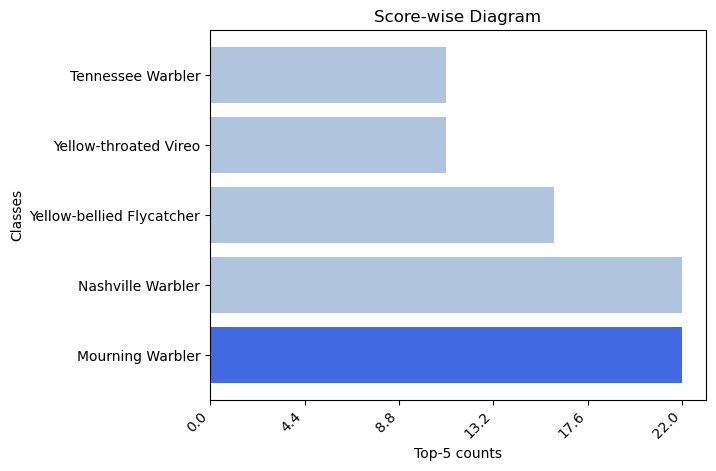

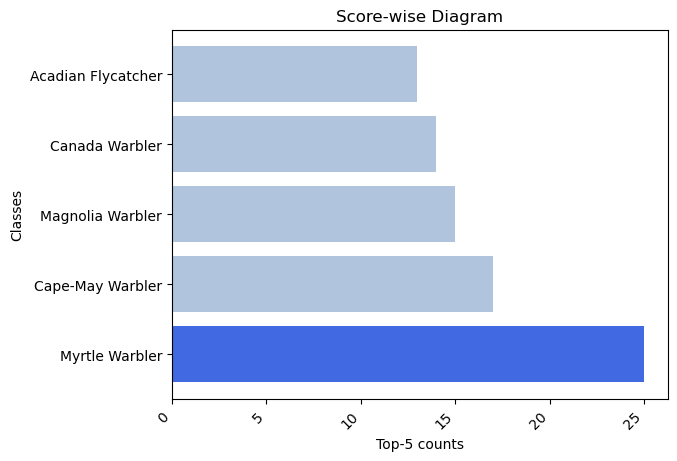

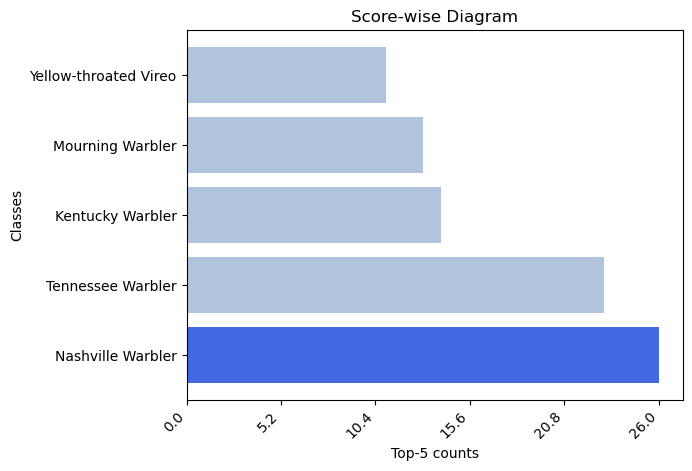

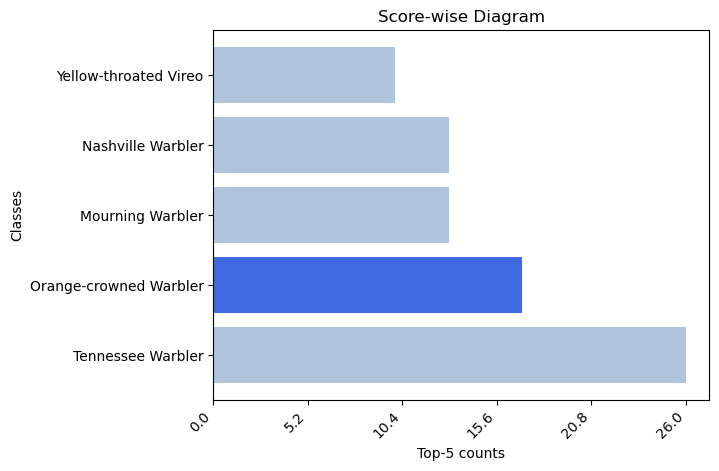

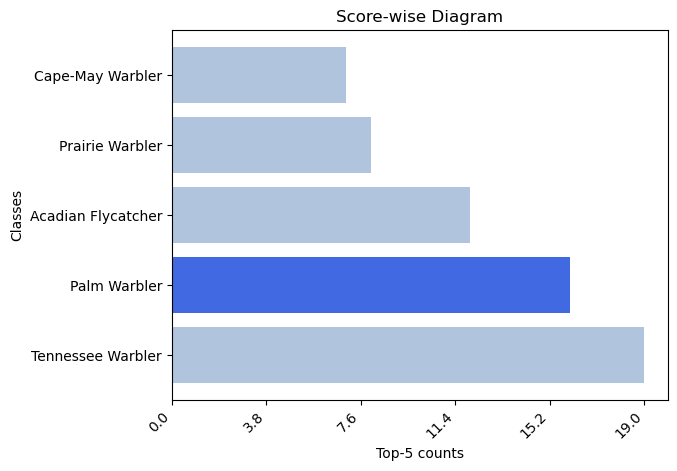

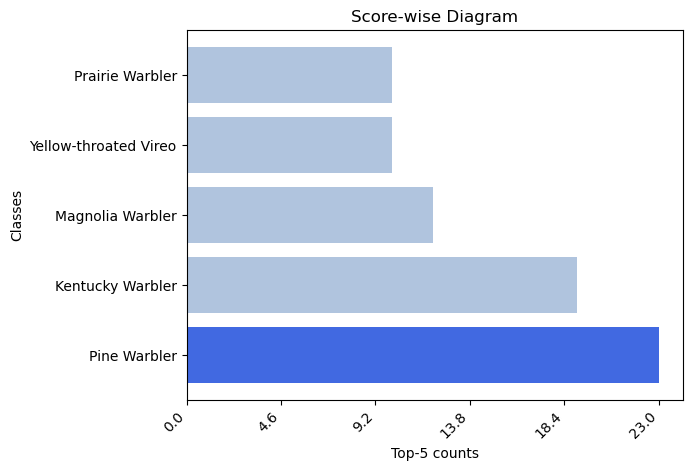

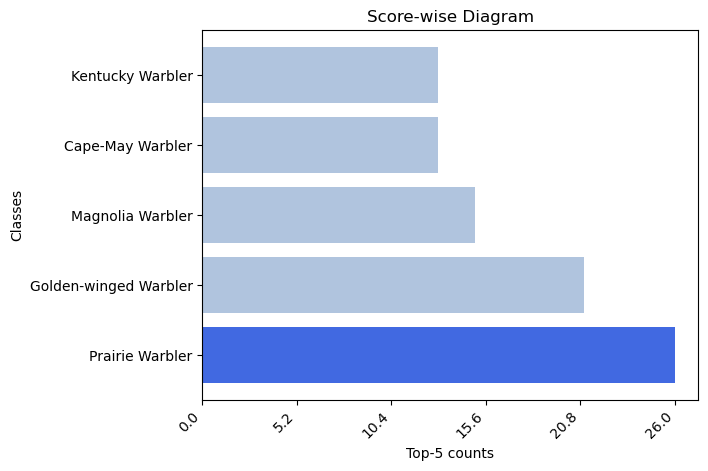

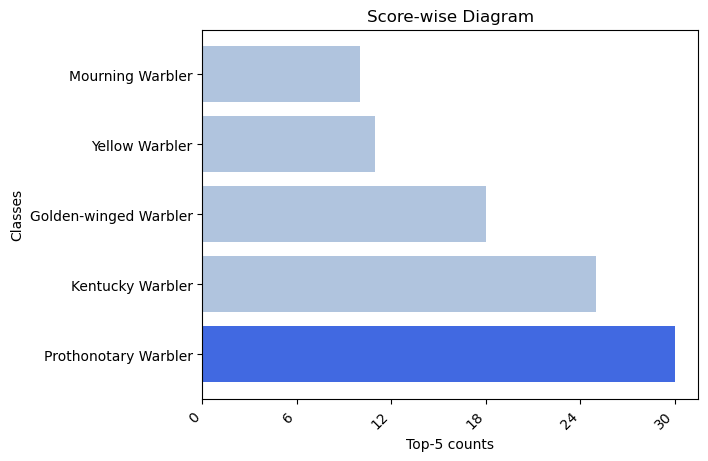

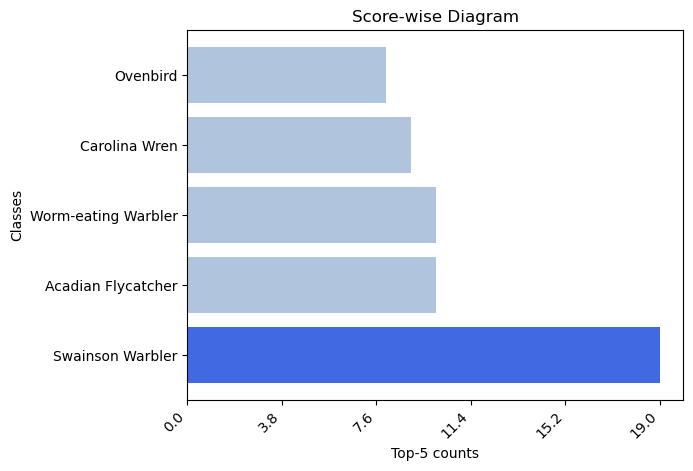

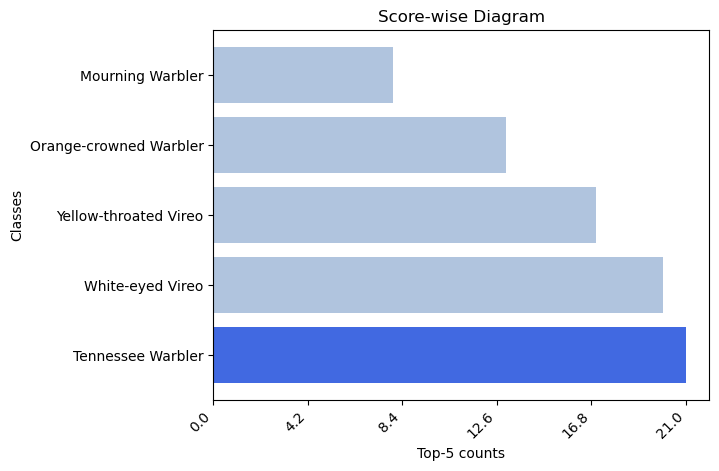

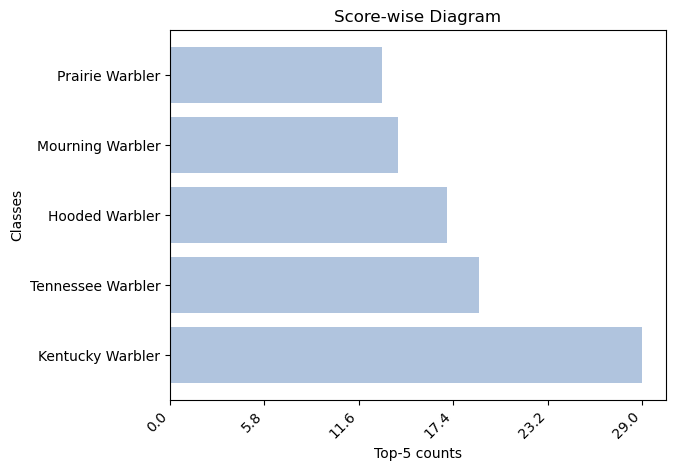

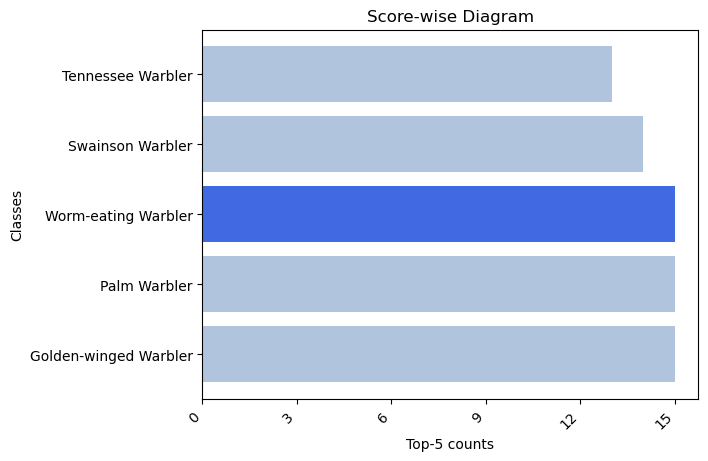

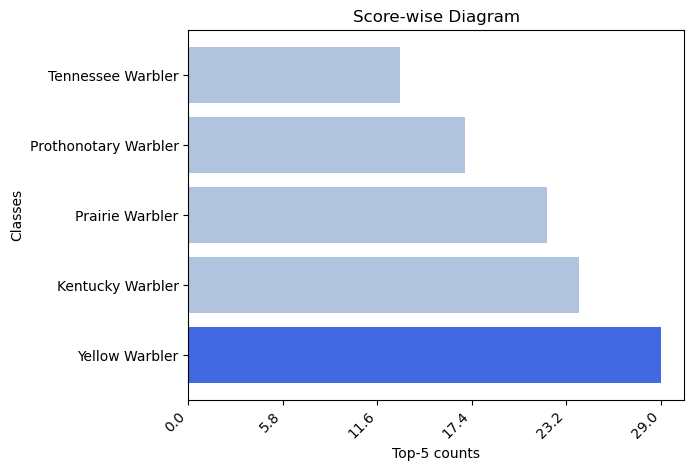

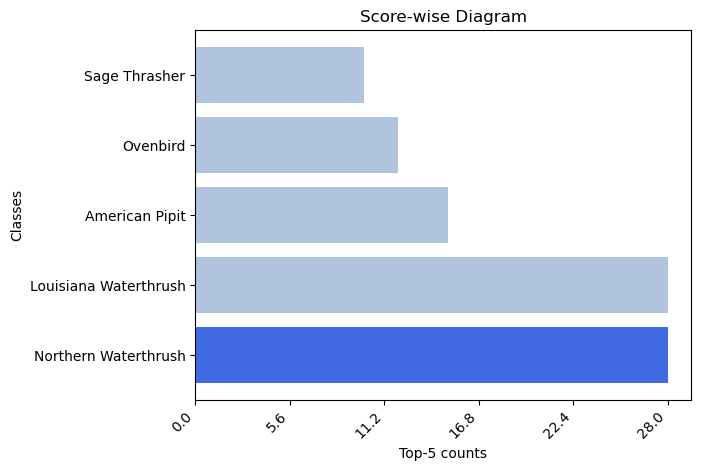

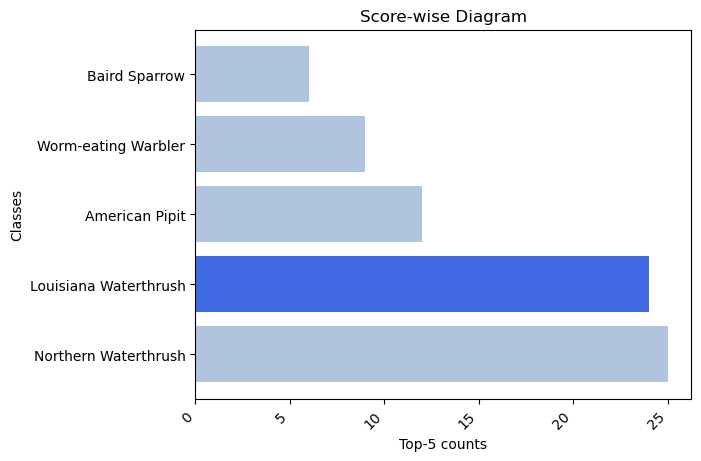

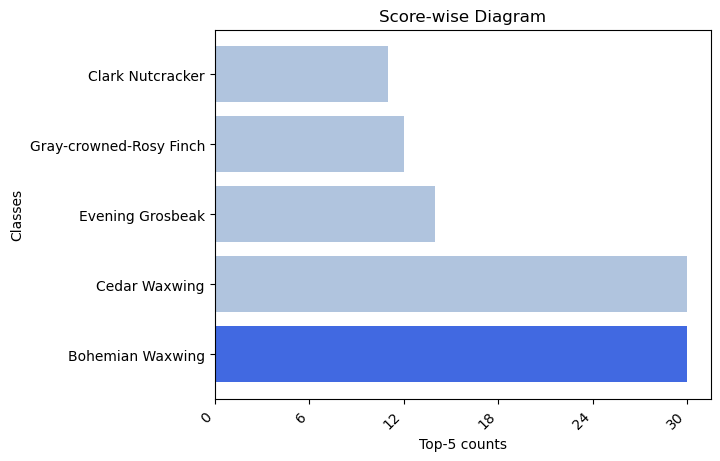

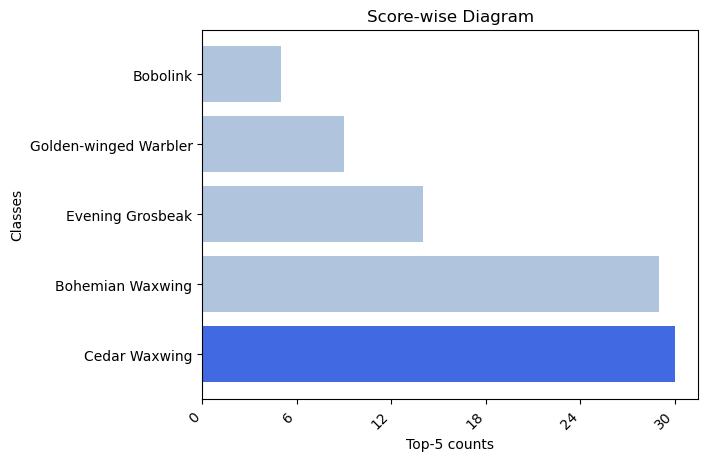

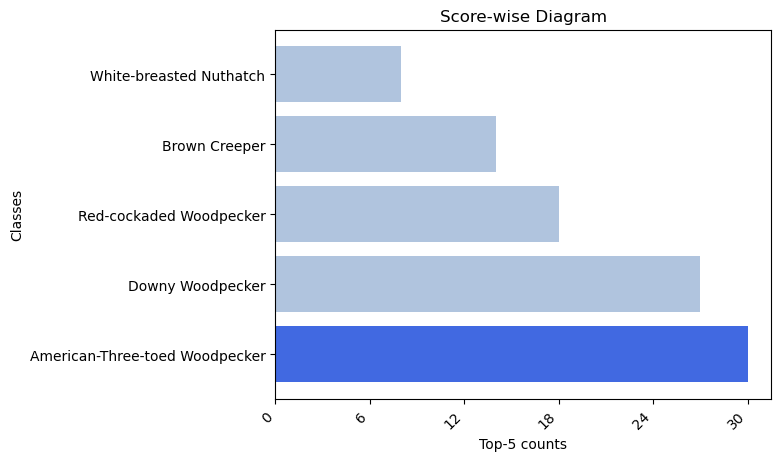

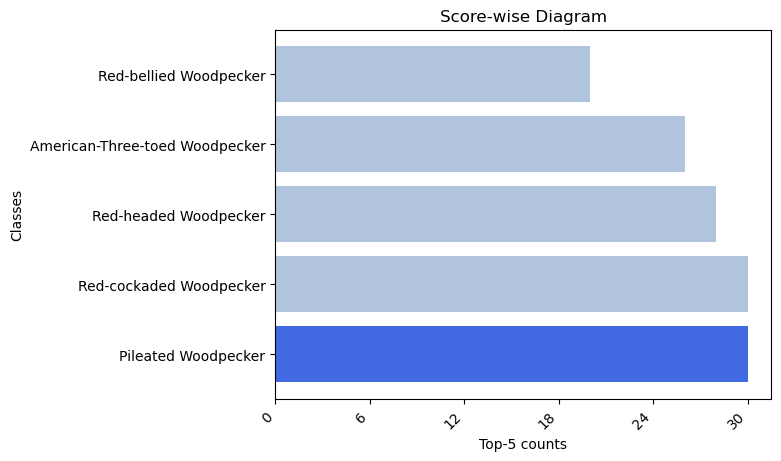

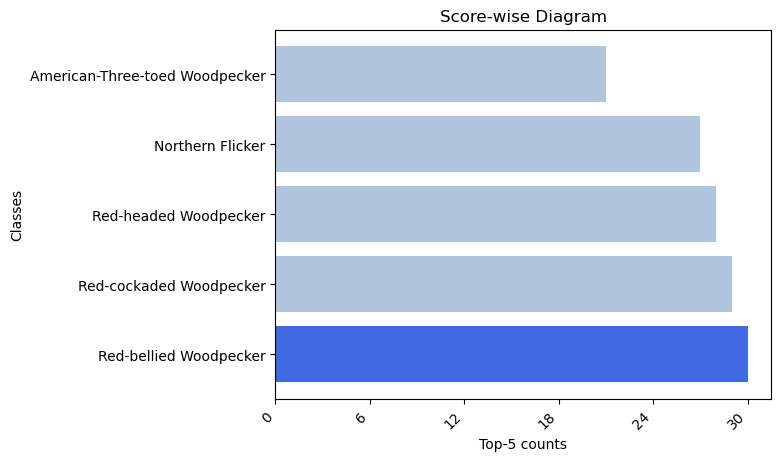

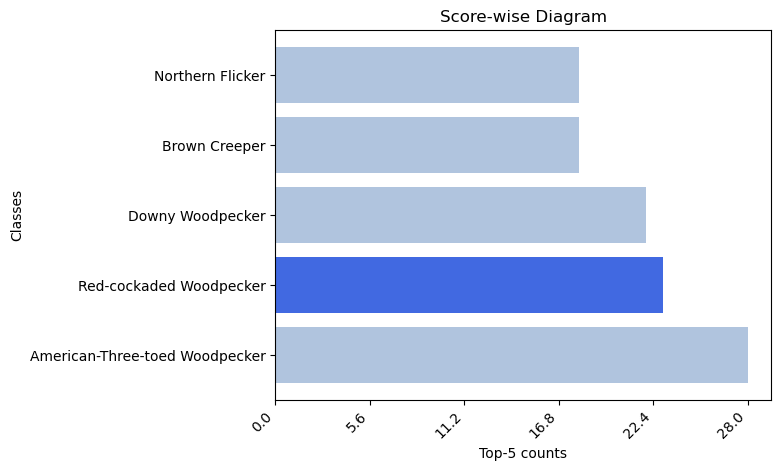

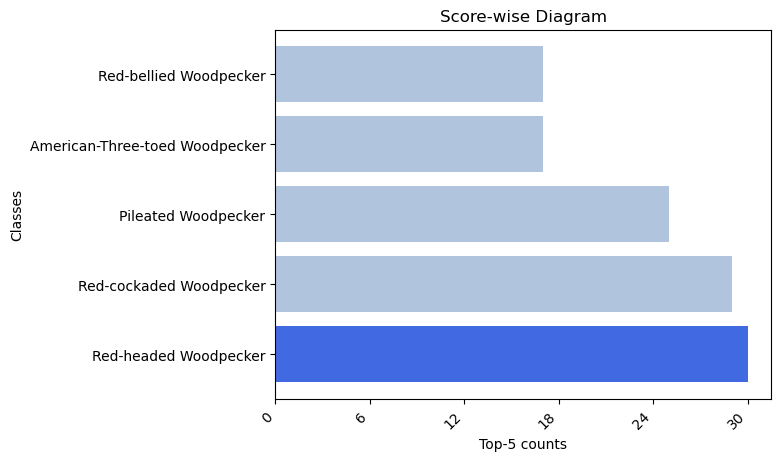

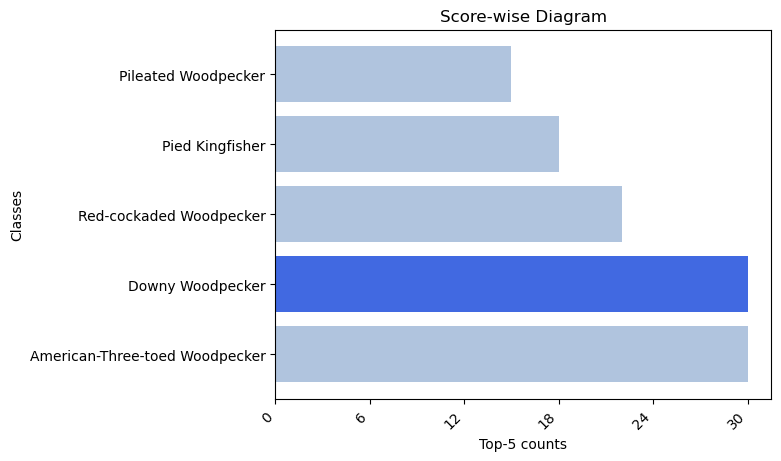

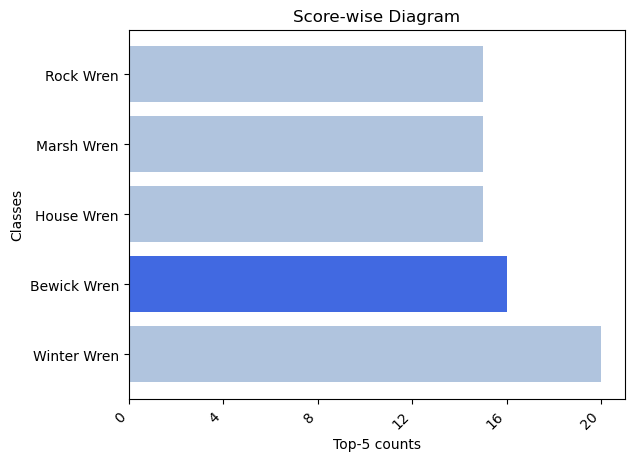

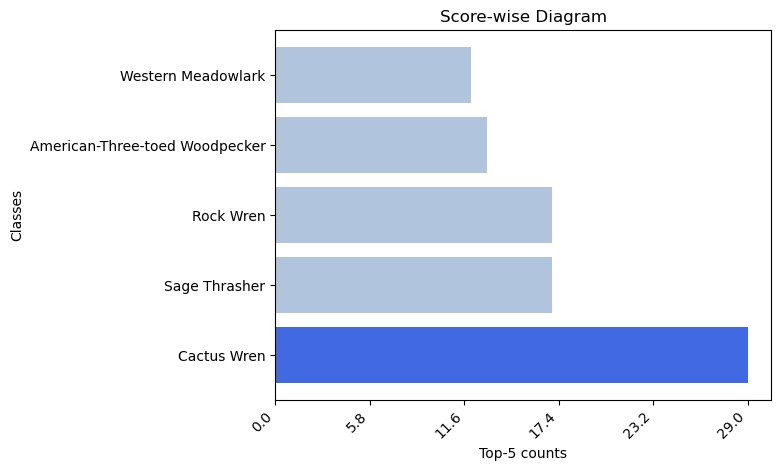

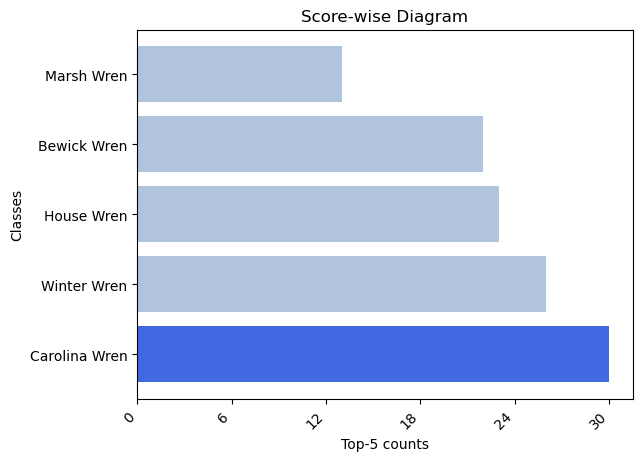

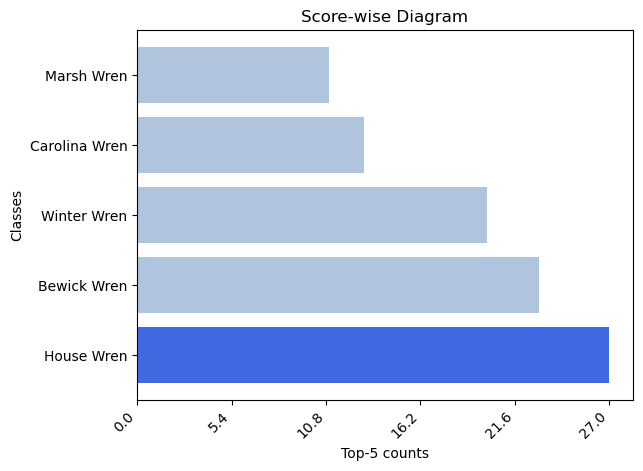

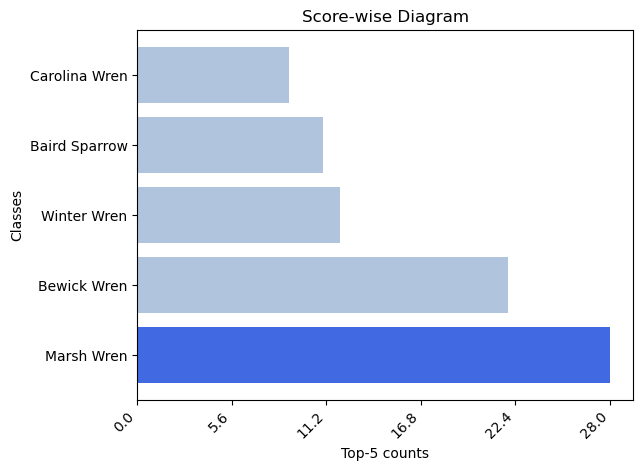

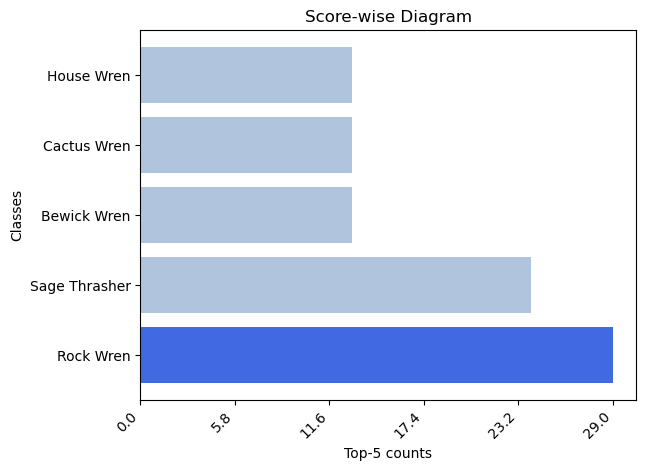

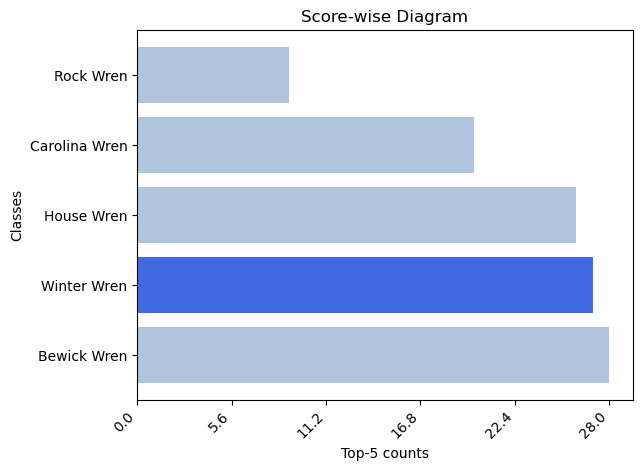

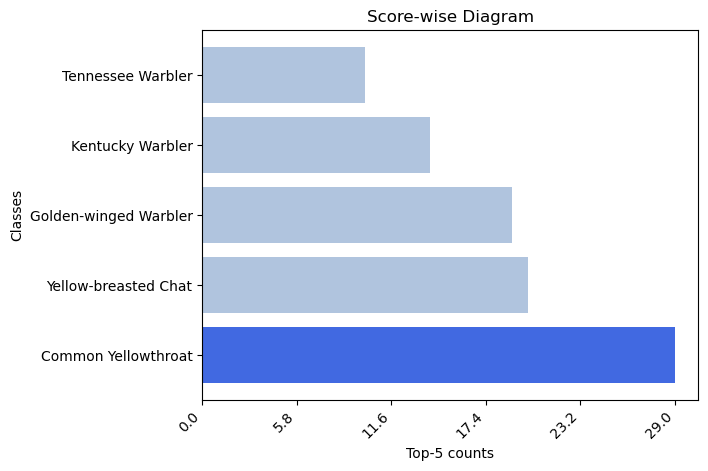

In [11]:
with open('top5.txt', 'r') as file:
    top5 = json.load(file)

for class_ in top5.keys():
    create_graph(class_, top5[class_][0:5])

In [12]:
top5[class_][0:5]

[['Common Yellowthroat', 29],
 ['Yellow-breasted Chat', 20],
 ['Golden-winged Warbler', 19],
 ['Kentucky Warbler', 14],
 ['Tennessee Warbler', 10]]

# Generate attributes functions

In [13]:
def logs():
    logging.basicConfig(
        level=logging.DEBUG,            # Set the minimum log level to DEBUG
        filename='gpt_3_my_cub.log',        # Specify the log file name
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )

    logger = logging.getLogger(__name__)
    return logger

In [14]:
def get_completion(prompt, logger, model="gpt-3.5-turbo", temperature=0., max_tokens=300):
    messages = [{'role':'system', 'content':"""
    Use this as an example to know how to answer the question asked by the user:
    Remeber to not use the category 1 name in the output of category2 name and vice-a-versa.
    As you can see in the given example, the answer for tiger does not contains the word lion, and the answer for lion does not contains the word tiger
    ```Q: What are useful visual features for distinguishing a tiger from a lion in a photo?
    A: There are several useful visual features to tell the difference between a tiger and a lion in a photo:-

    Tigers have the following features that a can distinguish it from a lion:
    - they have orange coats with vertical black stripes
    - they are generally larger and robust
    - they often have a more rounded face with prominent cheekbones
    - their ears are usually smaller and rounded
    - their tails are long and have a characteristic white spot at the tip.
    - they are found in a variety of habitats, including dense forests and grasslands

    Lions have the following features that can distinguish it from a tiger:
    - they have a tawny or beige coat, and their fur is often smoother and they have a mane
    - they have a more compact and muscular build
    - they have a more squared-off face
    - their ears are large and often have a more pointed shape.
    - their tails are shorter, ending in a tuft of hair.
    - their habitats are savannas and open woodlands.
    ```
    """},
    {"role": "user", "content": prompt}]
    
    try:
        print(messages)
        logger.debug(f'Input: {messages}')
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens
        )
        logger.debug(f'Output: {response}')
    except Exception as e:
        logger.error(f'error: {str(e)}')
        raise e
    return response.choices[0].message["content"]


# Create Attributes of Pairs from Top-5 Distribution

In [15]:
def generate_attributes(class1, class2):
    logger = logs()
    
    prompt = f"""
    Q: What are useful features for distinguishing a {class1} from {class2} in a photo?
    A: There are several useful visual features to tell the difference between a {class1} and a {class2} in a photo
    [
    """
#     print(prompt)
    response = get_completion(prompt, logger)
#     response = get_completion_dummy(prompt)
    answer = response
    print(response)
    
    return answer

# Generate Pairs

In [18]:
def generate_attributes_dummy(class1, class2):
    return """Black-footed Albatross have the following features that can distinguish them from Sooty Albatross:
- Black-footed Albatross have a black back and wings, with a white head, neck, and underparts.
- Black-footed Albatross have a yellow bill with a dark tip.
- Black-footed Albatross have a wingspan of around 6 feet.
- Black-footed Albatross have a distinctive black "M" shape on their upper wings when seen from above.
- Black-footed Albatross have a long, slender body shape.

Sooty Albatross have the following features that can distinguish them from Black-footed Albatross:
- Sooty Albatross have a dark brown or blackish-brown plumage all over their body.
- Sooty Albatross have a pale bill with a dark tip.
- Sooty Albatross have a wingspan of around 7 feet.
- Sooty Albatross have a more rounded body shape compared to Black-footed Albatross.
- Sooty Albatross have a more uniform coloration without any distinct patterns on their wings.

These visual features can help in distinguishing between a Black-footed Albatross and a Sooty Albatross in a photo."""

In [19]:
def process_response(differences, class1, class2, descriptor_dict: dict):
    lines = differences.split("[")
    for index, descriptor in enumerate(lines):
        if (descriptor != '') and (descriptor.startswith('[')):
            while lines.startswith(']'):
                
            descriptor_dict[class1].add(descriptor)
        elif (descriptor != '') and (descriptor.startswith(f'- {class2}')):
            descriptor_dict[class2].add(descriptor)
        elif (descriptor != '') and (descriptor.startswith('- ')):
            html_string = f'<font color="red">{str(descriptor)}</font>'
            display(HTML(html_string))

In [20]:
def intialize_descriptor_dict(classes):
    dict_ = dict()
    for class_ in classes:
        dict_[f"{class_}"] = set()
    return dict_

In [25]:
descriptor_dict = intialize_descriptor_dict(top5.keys())

In [26]:
already_seen = set()
total_pairs = 0

for class_ in top5.keys():
    number_of_pairs = 0
    for top_class, count in top5[class_][0:6]:
        if class_ == top_class or (class_, top_class) in already_seen or number_of_pairs >=5:
            continue
        response = generate_attributes(class_, top_class)
        process_response(response, class_, top_class, descriptor_dict)
        already_seen.add((class_, top_class))
        already_seen.add((top_class, class_))
        number_of_pairs += 1
        total_pairs += 1
    print(descriptor_dict)

[{'role': 'system', 'content': "\n    Use this as an example to know how to answer the question asked by the user:\n    Remeber to not use the category 1 name in the output of category2 name and vice-a-versa.\n    As you can see in the given example, the answer for tiger does not contains the word lion, and the answer for lion does not contains the word tiger\n    ```Q: What are useful visual features for distinguishing a tiger from a lion in a photo?\n    A: There are several useful visual features to tell the difference between a tiger and a lion in a photo:-\n\n    Tigers have the following features that a can distinguish it from a lion:\n    - Tigers have orange coats with vertical black stripes\n    - Tigers are generally larger and robust\n    - Tigers often have a more rounded face with prominent cheekbones\n    - Tiger ears are usually smaller and rounded\n    - Tiger tails are long and have a characteristic white spot at the tip.\n    - Tigers are found in a variety of habitat

[{'role': 'system', 'content': "\n    Use this as an example to know how to answer the question asked by the user:\n    Remeber to not use the category 1 name in the output of category2 name and vice-a-versa.\n    As you can see in the given example, the answer for tiger does not contains the word lion, and the answer for lion does not contains the word tiger\n    ```Q: What are useful visual features for distinguishing a tiger from a lion in a photo?\n    A: There are several useful visual features to tell the difference between a tiger and a lion in a photo:-\n\n    Tigers have the following features that a can distinguish it from a lion:\n    - Tigers have orange coats with vertical black stripes\n    - Tigers are generally larger and robust\n    - Tigers often have a more rounded face with prominent cheekbones\n    - Tiger ears are usually smaller and rounded\n    - Tiger tails are long and have a characteristic white spot at the tip.\n    - Tigers are found in a variety of habitat

KeyboardInterrupt: 